## Classification Model with Linear Model

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai import *
from fastai.text import *
np.set_printoptions(threshold=50, edgeitems=20)

In [5]:
import parse_inputs

from pathlib import Path

import numpy as np
import pandas as pd
from pandas_plink import read_plink

from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import metrics

#from ggplot import *
PATH=Path('ddat/crowdAI/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn import linear_model
import crowdai

In [8]:
import random

In [9]:
from snp2h import *

/home/ahmadA/anaconda3/envs/dereck/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
from models import save_model

# Loading Genotype and Phenotype

In [11]:
tz_plink = read_plink('ddat/crowdAI/all2964/bin_final_strand')
tz_maf = pd.read_csv(PATH/'TZ14_one.frq',delim_whitespace=True)
all_meta = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)
all_meta.head()

Mapping files: 100%|██████████| 3/3 [00:01<00:00,  1.24it/s]


ID  height             ChipID  nationality  gender  \
9992564090_R01C01  TL2257   177.0  9992564090_R01C01            0       1   
9992564090_R05C01  TL0067   155.0  9992564090_R05C01            0       2   
9992564090_R07C01  TL0139   143.5  9992564090_R07C01            0       2   
9992564090_R08C01  TL0279   161.9  9992564090_R08C01            0       2   
9992564137_R01C01  TL1090   155.2  9992564137_R01C01            0       2   

                   biclass  triclass   residual  
9992564090_R01C01        1         1   8.606139  
9992564090_R05C01        0         0  -1.518641  
9992564090_R07C01        0        -1 -13.018641  
9992564090_R08C01        1         1   5.381359  
9992564137_R01C01        0         0  -1.318641

# Filter genotype  

In [12]:
tz_maf_filter = tz_maf.apply(select_snp, axis=1)
tz_maf_new=tz_maf.loc[tz_maf_filter==1,]
tz_sample_index = [i for i,x in enumerate(tz_plink[1].iid) if x in list(all_meta.index)]
tz_plink=plink_slice(tz_plink,list(tz_maf_new.index),tz_sample_index)

# Get GWAS 

In [13]:
snps = {'tz_a':pd.read_csv(TMP_PATH/'SNPs_GWAS_Pincrease_Residual_of_Gender.csv',index_col=0),
       'tz_f':pd.read_csv(TMP_PATH/'SNPs_GWAS_TZ_Female.csv',index_col=0),
       'tz_m':pd.read_csv(TMP_PATH/'SNPs_GWAS_TZ_Male.csv',index_col=0),
       'os_a':pd.read_csv(TMP_PATH/'SNPs_GWAS_Pincrease_Residual_of_Gender_OS.csv',index_col=0),
       'os_f':pd.read_csv(TMP_PATH/'SNPs_GWAS_OS_Female.csv',index_col=0),
       'os_m':pd.read_csv(TMP_PATH/'SNPs_GWAS_OS_Male.csv',index_col=0),
       'other':pd.read_csv(TMP_PATH/'snps_sorted_p_val_v2.csv',index_col=0)}

In [14]:
snp_pool = set(tz_plink[0].snp)
len(snp_pool)

684066

In [15]:
def topn_snp(s,p,t=500):
    n = 0
    snp = []
    for x in s.index:
        if x in p:
            n +=1
            snp.append(x)
            if n>=t:
                break
    return snp

In [16]:
snp_list=[{k:topn_snp(v,snp_pool,t=n) for k,v in snps.items()} for n in [50,100,200,300,500,1000,2000,3000,5000,10000]]

# TTS GWAS 

In [17]:
tts_snps = {'tz_a':pd.read_csv('TTS_Model/gwas_trn_result.csv',index_col=0),
       'tz_f':pd.read_csv('TTS_Model/gwas_trn_result_female.csv',index_col=0),
       'tz_m':pd.read_csv('TTS_Model/gwas_trn_result_male.csv',index_col=0)
       }

In [18]:
tts_list = [{k:topn_snp(v,snp_pool,t=n) for k,v in tts_snps.items()} for n in [50,100,200,300,500,1000]]

In [19]:
len(set(tts_list[4]['tz_a']).intersection(snp_list[4]['tz_a']))

202

In [20]:
snp = tts_list[5]
snp = set(snp['tz_a']+snp['tz_f']+snp['tz_m'])

In [30]:
tz_sub = parse_model_input(tz_meta,snp,tz_plink)

(2671, 7) (2747, 7) (2747, 2671)


In [25]:
paper_snp = pd.read_csv(PATH/'snps_sorted_p_val_v2.csv')

In [26]:
paper_snp_top = paper_snp.iloc[0:2732,[0,1,3]]

In [27]:
paper_snp_top.columns = ['chrom','snp','pos']

In [28]:
paper_sp = [str(x)+'_'+str(y) for x,y in zip(paper_snp_top.chrom,paper_snp_top.pos)]

In [31]:
tz_snp =tz_sub[0]

In [32]:
tz_snp['sp']=  [str(x)+'_'+str(y) for x,y in zip(tz_snp.chrom,tz_snp.pos)]

In [33]:
paper_snp_top_sort=paper_snp_top.sort_values(['chrom', 'pos'])

In [ ]:
247	1	rs425277	0.0	2069172	T	C	247

In [34]:
paper_snp_top_sort.head()

chrom         snp      pos
1684      1  rs12410859  2038732
1376      1    rs425277  2069172
2713      1   rs2257182  2082566
2201      1    rs263533  2163568
1687      1    rs263526  2173504

In [36]:
paper_snp_top

chrom         snp        pos
0         3    rs724016  141105570
1         3   rs6764769  141100280
2         3   rs6763931  141102833
3         3   rs6440003  141094209
4         3   rs2871960  141121814
5         3   rs9846396  141140968
6         3   rs7624084  141093285
7        20   rs4911178   33952620
8        20   rs6087704   34001058
9        20   rs6088813   33975181
10       20   rs6060371   33913322
11       20   rs6060373   33914208
12       20   rs4911494   33971914
13       20   rs6088791   33907909
14       20   rs1406948   33905619
15       20    rs878639   33894463
16        3   rs7613516  141079309
17       20   rs6060355   33890061
18        3   rs1346408  141072289
19        3   rs6784404  141073675
20       12      rs8756   66359752
21        7     rs42039   92244422
22       12   rs1042725   66358347
23        7      rs8179   92236164
24        7   rs2282978   92264410
25       12   rs1351394   66351826
26        4   rs1812175  145574844
27        7      rs4272   92236829
28        4   rs7689420  145568352
29        7   rs2282979   92264993
...     ...         ...        ...
2702      6   rs7745040   32664332
2703     12   rs1599750   58242545
2704      5  kgp8625421   32775047
2705      6    rs209152   28846462
2706      6   rs9268657   32409656
2707     11   rs4320932    2171601
2708      6   rs1264624   30255089
2709      3   rs2276749   11643465
2710     10   rs2450445   93038530
2711     18  kgp6010749   46971732
2712     11   rs4553350   12759834
2713      1   rs2257182    2082566
2714      6   rs3130521   31196376
2715     17   rs2271028   40841397
2716      6   rs1931989  142586578
2717      6    rs714470   29191411
2718      6    rs389663  117868051
2719     17  kgp8359732   38603549
2720      8  rs13277090   25313456
2721      9   rs1127152  139335599
2722      2    rs698790   44683018
2723      6   rs9268607   32400538
2724      6  rs16896081   29811709
2725     11    rs214933   17194584
2726     12   rs2897951   46809206
2727      4   rs6838153  122720999
2728      6   rs3130623   31597700
2729      9  rs10821041   95694499
2730     14  rs17192586   68454505
2731     12  rs17485141   24213634

[2732 rows x 3 columns]

In [37]:
'kgp1173984' in list(paper_snp_top.snp)

True

In [38]:
set(tz_snp.sp).intersection(list(paper_sp))

{'11_47449544',
 '11_47454701',
 '11_47468569',
 '11_47469439',
 '11_47969152',
 '11_48058313',
 '13_50859990',
 '2_233149600',
 '2_233180919',
 '2_25359254',
 '2_25448050',
 '3_141079309',
 '3_141093285',
 '3_141094209',
 '3_141100280',
 '3_141102833',
 '3_141105570',
 '3_141121814',
 '3_141140968',
 '3_141143430',
 '3_141145315',
 '4_82134787',
 '4_82149831',
 '4_82154710',
 '4_82184234',
 '4_82187030',
 '4_82192994',
 '4_82226349',
 '4_82279666',
 '4_82287755',
 '4_82325636',
 '6_31578772',
 '6_31583827',
 '6_31589676',
 '6_31593476',
 '6_81460295',
 '6_81463045',
 '7_2754625',
 '7_2768864',
 '7_2831083',
 '8_25313456',
 '9_98209594'}

In [39]:
os_plink = read_plink('ddat/crowdAI/OpenSNP_train')

Mapping files: 100%|██████████| 3/3 [00:12<00:00,  5.65s/it]


In [40]:
os_meta = all_meta.loc[os_plink[1].iid,]

In [41]:
os_sub = parse_model_input(os_meta,set(paper_snp_top),os_plink)

(684066, 7) (2747, 7) (2747, 684066)


In [42]:
tz_snp = pd.merge(tz_sub[0], paper_snp_top_sort, how='left', on=['pos'])

In [43]:
tz_snp.loc[tz_snp.snp_y.notna(),]

chrom_x        snp_x   cm        pos a0 a1       i           sp  chrom_y  \
258        2   rs10202934  0.0   25359254  C  T   69643   2_25359254      2.0   
259        2    rs4665783  0.0   25448050  G  A   69658   2_25448050      2.0   
458        2   rs13020779  0.0  233149600  A  G  119933  2_233149600      2.0   
459        2     rs871411  0.0  233180919  G  A  119942  2_233180919      2.0   
564        3    rs7613516  0.0  141079309  G  T  161997  3_141079309      3.0   
565        3    rs7624084  0.0  141093285  C  T  161999  3_141093285      3.0   
566        3    rs6440003  0.0  141094209  A  G  162000  3_141094209      3.0   
567        3    rs6764769  0.0  141100280  G  A  162001  3_141100280      3.0   
568        3    rs6763931  0.0  141102833  A  G  162002  3_141102833      3.0   
569        3     rs724016  0.0  141105570  G  A  162004  3_141105570      3.0   
570        3    rs2871960  0.0  141121814  C  A  162006  3_141121814      3.0   
571        3    rs9846396  0.0  141140968  T  C  162010  3_141140968      3.0   
572        3   kgp1173984  0.0  141143430  A  G  162011  3_141143430      3.0   
573        3    rs6762826  0.0  141145315  G  A  162012  3_141145315      3.0   
714        4     rs710839  0.0   82134787  C  T  197775   4_82134787      4.0   
716        4     rs710841  0.0   82149831  T  C  197780   4_82149831      4.0   
717        4    rs1712374  0.0   82154710  C  T  197781   4_82154710      4.0   
718        4    rs1878528  0.0   82184234  G  A  197783   4_82184234      4.0   
719        4    rs1901568  0.0   82187030  C  T  197784   4_82187030      4.0   
720        4    rs6535239  0.0   82192994  A  G  197785   4_82192994      4.0   
721        4    rs2034629  0.0   82226349  G  A  197788   4_82226349      4.0   
722        4  kgp11672887  0.0   82279666  A  G  197793   4_82279666      4.0   
723        4   rs11723619  0.0   82287755  T  G  197796   4_82287755      4.0   
724        4   rs17500149  0.0   82325636  T  C  197801   4_82325636      4.0   
951        6    rs2844477  0.0   31578772  T  C  288486   6_31578772      6.0   
952        6    rs2259571  0.0   31583827  T  G  288491   6_31583827      6.0   
953        6    rs2844472  0.0   31589676  A  G  288500   6_31589676      6.0   
955        6    rs2260000  0.0   31593476  A  G  288507   6_31593476      6.0   
1003       6   rs11752339  0.0   81460295  A  G  302718   6_81460295      6.0   
1004       6   rs13197404  0.0   81463045  G  T  302719   6_81463045      6.0   
1072       7    rs4719646  0.0    2754625  G  A  327503    7_2754625      7.0   
1074       7     rs798532  0.0    2768864  C  T  327511    7_2768864      7.0   
1075       7    rs2533888  0.0    2831083  C  T  327529    7_2831083      7.0   
1219       8   rs13277090  0.0   25313456  C  T  381511   8_25313456      8.0   
1455       9     rs357564  0.0   98209594  G  A  432780   9_98209594      9.0   
1677      11    rs7105122  0.0   47449544  T  C  501977  11_47449544     11.0   
1678      11   rs10742805  0.0   47454701  A  G  501978  11_47454701     11.0   
1679      11    rs3824867  0.0   47468569  A  G  501980  11_47468569     11.0   
1680      11   kgp6620049  0.0   47469439  A  G  501981  11_47469439     11.0   
1688      11    rs1681630  0.0   47969152  T  C  502030  11_47969152     11.0   
1691      11    rs1113480  0.0   48058313  C  A  502040  11_48058313     11.0   
1942      13   kgp2775521  0.0   50859990  C  T  573319  13_50859990     13.0   

            snp_y  
258    rs10202934  
259     rs4665783  
458    rs13020779  
459      rs871411  
564     rs7613516  
565     rs7624084  
566     rs6440003  
567     rs6764769  
568     rs6763931  
569      rs724016  
570     rs2871960  
571     rs9846396  
572    kgp1173984  
573     rs6762826  
714      rs710839  
716      rs710841  
717     rs1712374  
718     rs1878528  
719     rs1901568  
720     rs6535239  
721     rs2034629  
722   kgp11672887  
723    rs11723619  
724    rs17500149  
951     rs2844477  
9

(42, 7) (2747, 7) (2747, 42)
(2747, 16)


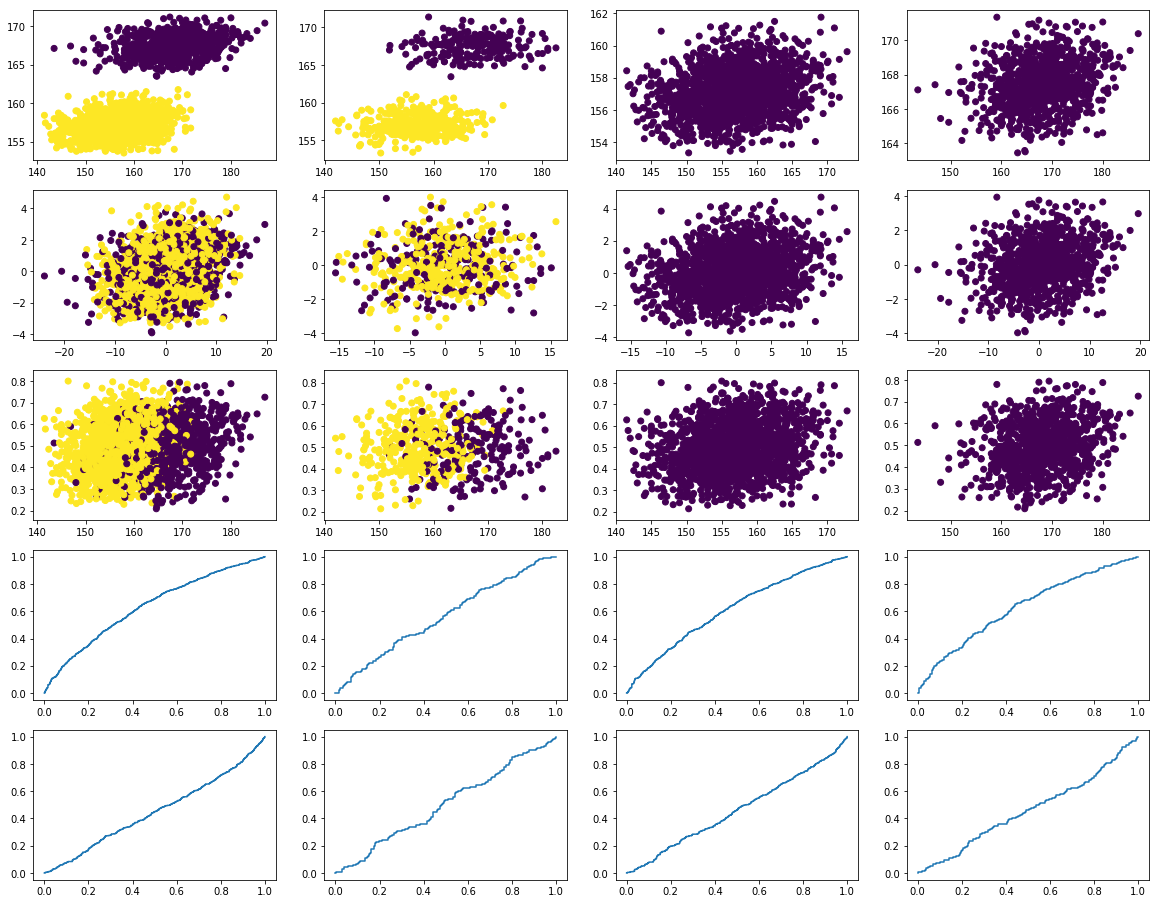

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.632137  0.449455
val     33.542486  0.429253  0.559181  0.501864
female  28.111462 -0.002415  0.611464  0.461224
male    38.206925 -0.006473  0.629298  0.458912


(         rt        rv        rf        rm        ht        hv        hf  \
 r  0.062747 -0.004936  0.040588  0.049560  0.514261  0.426436  0.040588   
 c  0.062747 -0.004936  0.040588  0.049560  0.514261  0.426436  0.040588   
 b  0.062765 -0.004525  0.040466  0.049955  0.514270  0.426670  0.040466   
 t  0.060690 -0.013285  0.038396  0.044569  0.513195  0.421670  0.038396   
 
          hm  
 r  0.049560  
 c  0.049560  
 b  0.049955  
 t  0.044569  ,
           rt         rv         rf         rm         ht         hv  \
 r  29.332458  33.708050  26.905499  36.079850  29.332458  33.708050   
 c  29.332458  33.708050  26.905499  36.079850  29.332458  33.708050   
 b  29.331897  33.694274  26.908929  36.064845  29.331897  33.694274   
 t  29.396828  33.988101  26.966971  36.269316  29.396828  33.988101   
 
           hf         hm  
 r  26.905499  36.079850  
 c  26.905499  36.079850  
 b  26.908929  36.064845  
 t  26.966971  36.269316  )

In [143]:
tmp(tz_meta,list(tz_snp.snp_x[tz_snp.snp_y.notna()]),tz_plink,val_idx=val_idx)

# Model for Prediction

In [29]:
tz_meta=all_meta.loc[tz_plink[1].iid,]

In [37]:
val_idx = pd.read_csv('TTS_Model/gwas_val_idx.csv',index_col=0,header=None)

In [39]:
val_idx = list(val_idx.iloc[:,0])

In [41]:
regr = gn_residual(tz_meta.iloc[val_idx,:],t=False)
save_model(regr,'gender_residual',out_dir='TTS_Model/')

for prediction, I need to save (residual,pca,predict)model by joblib and model_selected_snp.bim

## Model 1 with merged top 200 snps

In [16]:
snp = snp_list[2]
snp = set(snp['tz_a']+snp['tz_f']+snp['tz_m'])
meta = tz_meta
tz_snp_index = [i for i,x in enumerate(tz_plink[0].snp) if x in snp]
tz_sample_index = [i for i,x in enumerate(tz_plink[1].iid) if x in list(meta.index)]
tz_sub=plink_slice(tz_plink,tz_snp_index,tz_sample_index)

In [48]:
refbim = tz_sub[0]

In [89]:
def write_bim(bim,path):
    bim.iloc[:,0:6].to_csv(path,sep='\t',index=False,header=False)

In [90]:
write_bim(refbim,path='full_model/top200_all/ref.bim')

# Full Data Model

In [23]:
def parse_model_input(meta,snp,plink):
    tz_snp_index = [i for i,x in enumerate(tz_plink[0].snp) if x in snp]
    tz_sample_index = [i for i,x in enumerate(tz_plink[1].iid) if x in list(meta.index)]
    tz_sub=plink_slice(tz_plink,tz_snp_index,tz_sample_index)
    
    all_bim = tz_sub[0]
    all_fam = tz_sub[1]
    all_bed_T= pd.DataFrame(tz_sub[2].compute()).T
    all_bed_T.fillna(-1,inplace=True)
    all_bed_T.index = list(all_fam.iid)
    all_bed_T.columns=list(all_bim.snp)
    print(all_bim.shape,all_fam.shape,all_bed_T.shape)
    return (all_bim,all_fam,all_bed_T)

In [128]:
X = parse_model_input(tz_meta,snp,tz_plink)[2]

(542, 7) (2747, 7) (2747, 542)


In [189]:
def snpXpath(snp,path):
    tz_sub = parse_model_input(tz_meta,snp,tz_plink)
    refbim = tz_sub[0]
    write_bim(refbim,path=path+'/ref.bim')
    X = tz_sub[2]
    pca = PCA(.95)
    X=pd.DataFrame(pca.fit_transform(X))
    save_model(pca,'pca_95',out_dir=path)
    print(X.shape)

    m = linear_model.LinearRegression()
    y= tz_meta.height - regr.predict(tz_meta[['gender','nationality']])  
    m.fit(X.values,np.array(y))
    save_model(m,'linear_regression',out_dir=path)

    y_pred = model_pred(m,[X])[0]
    print(metrics.r2_score(y,y_pred),metrics.mean_squared_error(y,y_pred))
    plt.scatter(y,y_pred,marker='o')

    mb = linear_model.LogisticRegression()
    y = tz_meta.biclass  
    mb.fit(X.values,np.array(y))
    save_model(mb,'logistic_avg',out_dir=path)

    fpr, tpr, _ = metrics.roc_curve(y, mb.predict_proba(X.values)[:,1],pos_label=1)
    print(metrics.auc(fpr,tpr))
    plt.plot(fpr,tpr)

    m25 = linear_model.LogisticRegression()
    y = ytop25
    m25.fit(X.values,np.array(y))
    save_model(m25,'logistic_25perc',out_dir=path)

    fpr, tpr, _ = metrics.roc_curve(y, m25.predict_proba(X.values)[:,1],pos_label=1)
    print(metrics.auc(fpr,tpr))
    plt.scatter(tz_meta.height,m25.predict_proba(X.values)[:,1],c=tz_meta.gender)
    #plt.plot(fpr,tpr)
    
    m15 = linear_model.LogisticRegression()
    y = ytop15
    m15.fit(X.values,np.array(y))
    save_model(m15,'logistic_15perc',out_dir=path)

    fpr, tpr, _ = metrics.roc_curve(y, m15.predict_proba(X.values)[:,1],pos_label=1)
    print(metrics.auc(fpr,tpr))
    plt.scatter(tz_meta.height,m15.predict_proba(X.values)[:,1],c=tz_meta.gender)
    
    print('success')

(542, 7) (2747, 7) (2747, 542)
(2747, 313)
0.556281568573735 14.027855516591703
0.8781421860040522
0.8973478364499144
0.9172991774048828
success


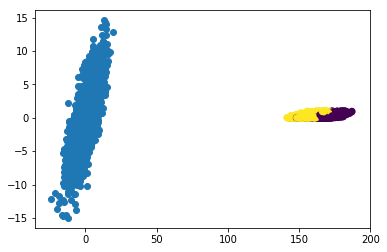

In [190]:
snp = snp_list[2]
snp = set(snp['tz_a']+snp['tz_f']+snp['tz_m'])
snpXpath(snp,path='full_model/top200_all')

(200, 7) (2747, 7) (2747, 200)
(2747, 110)
0.38288782619836736 19.509580397175068
0.7988995656152159
0.804058416935711
0.8149129613633369
success


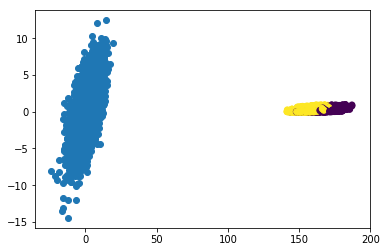

In [191]:
snpXpath(snp_list[2]['tz_a'],path='full_model/top200')

(300, 7) (2747, 7) (2747, 300)
(2747, 158)
0.45164885746669603 17.335747300579335
0.822611546344096
0.8317306233884423
0.850334957050621
success


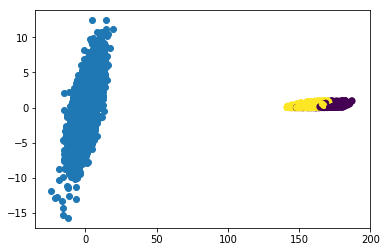

In [192]:
snpXpath(snp_list[3]['tz_a'],path='full_model/top300')

(808, 7) (2747, 7) (2747, 808)
(2747, 447)
0.6253896476713807 11.84305073961894
0.9077041009443655
0.9313868244097275
0.9543776575385728
success


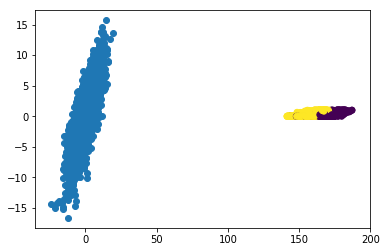

In [193]:
snp = snp_list[3]
snp = set(snp['tz_a']+snp['tz_f']+snp['tz_m'])
snpXpath(snp,path='full_model/top300_all')

(500, 7) (2747, 7) (2747, 500)
(2747, 261)
0.5566358223350418 14.016656025590509
0.8717843916227458
0.8835879323669404
0.9073184403111346
success


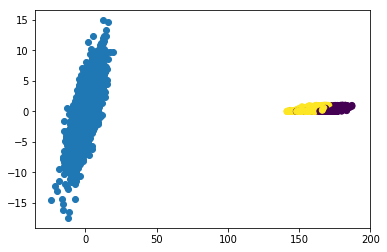

In [194]:
snpXpath(snp_list[4]['tz_a'],path='full_model/top500')

(1333, 7) (2747, 7) (2747, 1333)
(2747, 691)
0.725593560132965 8.675172403598335
0.9560992522050566
0.9751171877821354
0.9991769865787112
success


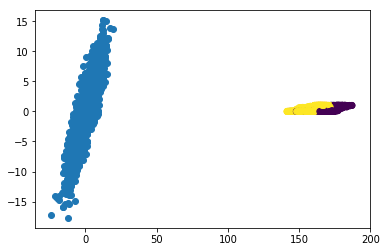

In [195]:
snp = snp_list[4]
snp = set(snp['tz_a']+snp['tz_f']+snp['tz_m'])
snpXpath(snp,path='full_model/top500_all')

# RF Full Model

In [196]:
from sklearn.ensemble import RandomForestClassifier

In [223]:
def snpXpath_rf(snp,path):
    tz_sub = parse_model_input(tz_meta,snp,tz_plink)
    refbim = tz_sub[0]
    write_bim(refbim,path=path+'/ref.bim')
    X = tz_sub[2]
    pca = PCA(.95)
    X=pd.DataFrame(pca.fit_transform(X))
    save_model(pca,'pca_95',out_dir=path)
    print(X.shape)
    
    mb = RandomForestClassifier(n_estimators=30,max_depth=4)
    y = tz_meta.biclass  
    mb.fit(X.values,np.array(y))
    save_model(mb,'rfc_avg',out_dir=path)

    fpr, tpr, _ = metrics.roc_curve(y, mb.predict_proba(X.values)[:,1],pos_label=1)
    print(metrics.auc(fpr,tpr))
    #plt.plot(fpr,tpr)

    m25 = RandomForestClassifier(n_estimators=30,max_depth=4)
    y = ytop25
    m25.fit(X.values,np.array(y))
    save_model(m25,'rfc_25perc',out_dir=path)

    fpr, tpr, _ = metrics.roc_curve(y, m25.predict_proba(X.values)[:,1],pos_label=1)
    print(metrics.auc(fpr,tpr))
    plt.scatter(tz_meta.height,m25.predict_proba(X.values)[:,1],c=tz_meta.gender)
    #plt.plot(fpr,tpr)
    
    m15 = RandomForestClassifier(n_estimators=30,max_depth=4)
    y = ytop15
    m15.fit(X.values,np.array(y))
    save_model(m15,'rfc_15perc',out_dir=path)

    fpr, tpr, _ = metrics.roc_curve(y, m15.predict_proba(X.values)[:,1],pos_label=1)
    print(metrics.auc(fpr,tpr))
    plt.scatter(tz_meta.height,m15.predict_proba(X.values)[:,1],c=tz_meta.gender)
    
    print('success')

(542, 7) (2747, 7) (2747, 542)
(2747, 313)
0.8852045170928344
0.9144930048464099
0.9041382829869427
success
(200, 7) (2747, 7) (2747, 200)
(2747, 110)
0.8663956665426172
0.8866525102381314
0.9148039931314458
success
(300, 7) (2747, 7) (2747, 300)
(2747, 158)
0.8746179120903588
0.9047243468902804
0.911621744286488
success
(808, 7) (2747, 7) (2747, 808)
(2747, 447)
0.8957884714681188
0.9144337789719256
0.9313918443239264
success
(500, 7) (2747, 7) (2747, 500)
(2747, 261)
0.8953209008315547
0.9205586011137352
0.9309317097554803
success
(1333, 7) (2747, 7) (2747, 1333)
(2747, 691)
0.9058444209068749
0.9238564711490542
0.9209039134445046
success


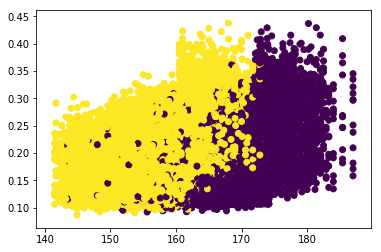

In [224]:
snp = snp_list[2]
snp = set(snp['tz_a']+snp['tz_f']+snp['tz_m'])
snpXpath_rf(snp,path='full_model/top200_all')

snpXpath_rf(snp_list[2]['tz_a'],path='full_model/top200')

snpXpath_rf(snp_list[3]['tz_a'],path='full_model/top300')

snp = snp_list[3]
snp = set(snp['tz_a']+snp['tz_f']+snp['tz_m'])
snpXpath_rf(snp,path='full_model/top300_all')

snpXpath_rf(snp_list[4]['tz_a'],path='full_model/top500')

snp = snp_list[4]
snp = set(snp['tz_a']+snp['tz_f']+snp['tz_m'])
snpXpath_rf(snp,path='full_model/top500_all')

In [222]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
snp = snp_list[2]
snp = set(snp['tz_a']+snp['tz_f']+snp['tz_m'])
X = parse_model_input(tz_meta,snp,tz_plink)[2]
pca = PCA(.95)
X=pd.DataFrame(pca.fit_transform(X))
samp_size=len(tz_meta)
train_ratio = 0.8
train_size = int(samp_size * train_ratio)
random.seed(1)
val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, tz_meta.biclass.values)
clf=RandomForestClassifier(n_estimators=30,max_depth=4)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(trn,y_trn)
fpr, tpr, _ = metrics.roc_curve(y_trn, clf.predict_proba(trn)[:,1],pos_label=1)
print(metrics.auc(fpr,tpr))
fpr, tpr, _ = metrics.roc_curve(y_val, clf.predict_proba(val)[:,1],pos_label=1)
print(metrics.auc(fpr,tpr))

(542, 7) (2747, 7) (2747, 542)
2747 2197
0.9182379460660003
0.6661022106391142


In [117]:
def y_boolean(x,m,f,g):
    if g==1:
        return int(x>m)
    elif g==2:
        return int(x>f)
    else:
        print('error')
        
def topn_percent(m,n=50):
    y=m.height
    mn = np.percentile(y.loc[list(m.gender==1)],100-n)
    fn = np.percentile(y.loc[list(m.gender==2)],100-n)
    yb= [y_boolean(x,mn,fn,m.gender.iloc[i]) for i,x in enumerate(y)]
    return yb

In [118]:
ytop25 = topn_percent(tz_meta,n=25)

In [187]:
ytop15 = topn_percent(tz_meta,n=15)

In [188]:
sum(ytop15)

409

In [143]:
os_plink= read_plink('ddat/crowdAI/OpenSNP_train')

Mapping files: 100%|██████████| 3/3 [00:12<00:00,  5.48s/it]


In [44]:
p_bim = os_plink[0]

In [45]:
p_bim.head()

chrom          snp   cm     pos      a0 a1  i
0     1  rs190214723  0.0  693625       T  C  0
1     1   rs72631875  0.0  705882       G  A  1
2     1   rs55727773  0.0  706368       A  G  2
3     1  rs113462541  0.0  706778       G  A  3
4     1  rs201939756  0.0  719489  CATAAT  C  4

In [46]:
def select_bim(arr):
    if arr[0]==0 or arr[0]==26:
        return 0
    elif arr[4]=='A' and arr[5]=='T':
        return 0
    elif arr[4]=='T' and arr[5]=='A':
        return 0
    elif arr[4]=='G' and arr[5]=='C':
        return 0
    elif arr[4]=='C' and arr[5]=='G':
        return 0
    else:
        return 1

In [49]:


result = pd.merge(refbim, p_bim, how='left', on=['chrom','pos'])

In [50]:
result

chrom        snp_x  cm_x        pos a0_x a1_x     i_x            sp  \
0        1    rs2821040   0.0    3406791    G    A     705     1_3406791   
1        1    rs6695346   0.0    3996946    G    A     866     1_3996946   
2        1     rs600933   0.0    4409496    C    T    1123     1_4409496   
3        1     rs528291   0.0    4414045    G    A    1124     1_4414045   
4        1    rs2649069   0.0    5750013    G    A    1859     1_5750013   
5        1   kgp3760276   0.0    5905501    T    C    1922     1_5905501   
6        1   rs12071731   0.0    6276167    G    T    2041     1_6276167   
7        1    rs1894647   0.0    7205950    T    C    2312     1_7205950   
8        1    rs4418630   0.0    7240456    G    A    2326     1_7240456   
9        1   rs10803341   0.0   15376091    T    C    4914    1_15376091   
10       1   rs10803355   0.0   15455192    T    C    4977    1_15455192   
11       1   rs35609485   0.0   16082976    T    C    5187    1_16082976   
12       1    rs6684802   0.0   16449680    T    C    5262    1_16449680   
13       1    rs9435734   0.0   17311190    G    A    5344    1_17311190   
14       1   kgp2901205   0.0   17314942    A    G    5346    1_17314942   
15       1    rs4433436   0.0   18331592    G    T    5786    1_18331592   
16       1   kgp1431741   0.0   18420144    G    A    5834    1_18420144   
17       1   rs12072266   0.0   18450595    T    C    5854    1_18450595   
18       1   rs11261067   0.0   18455424    A    G    5857    1_18455424   
19       1     rs109490   0.0   18572901    A    G    5947    1_18572901   
20       1   kgp5940272   0.0   18579935    C    T    5957    1_18579935   
21       1   kgp2481479   0.0   18860592    G    T    6135    1_18860592   
22       1  kgp15174767   0.0   23446272    G    A    7785    1_23446272   
23       1    rs7524076   0.0   24508710    G    A    8029    1_24508710   
24       1     rs894220   0.0   30183014    A    G    9149    1_30183014   
25       1    rs4259710   0.0   30184426    G    A    9150    1_30184426   
26       1    rs1866967   0.0   30185662    G    A    9152    1_30185662   
27       1   kgp5126670   0.0   30342698    G    T    9240    1_30342698   
28       1  kgp15209626   0.0   30541105    T    C    9347    1_30541105   
29       1   rs12562824   0.0   31854882    A    G    9875    1_31854882   
...    ...          ...   ...        ...  ...  ...     ...           ...   
2642    23  kgp22745825   0.0   71239857    T    C  785158   23_71239857   
2643    23    rs5951247   0.0   71250399    A    G  785160   23_71250399   
2644    23   rs12014839   0.0   71281692    C    T  785161   23_71281692   
2645    23    rs6653323   0.0   71293312    G    A  785165   23_71293312   
2646    23  kgp22780824   0.0   75987774    T    C  785460   23_75987774   
2647    23    rs6621367   0.0   79220877    A    G  785677   23_79220877   
2648    23  kgp22803904   0.0   79231118    C    T  785679   23_79231118   
2649    23  kgp22795119   0.0   79231201    T    C  785680   23_79231201   
2650    23    rs6524661   0.0   85732931    G    A  786287   23_85732931   
2651    23    rs4430266   0.0   95935841    C    A  787619   23_95935841   
2652    23   rs12156942   0.0  100133576    T    C  788079  23_100133576   
2653    23  kgp22764130   0.0  100673943    A    G  788165  23_100673943   
2654    23    rs1991340   0.0  105936406    G    A  788518  23_105936406   
2655    23  kgp22817007   0.0  113314976    C    T  788954  23_113314976   
2656    23    rs1218140   0.0  117424134    T    C  789365  23_117424134   
2657    23    rs1781973   0.0  117446408    A    G  789370  23_117446408   
2658    23    rs2507282   0.0  120895123    C    A  789834  23_120895123   
2659    23    rs6608076   0.0  122435853    T    C  790075  23_122435853   
2660    23    rs1003856   0.0  132988656    C    T  791349  23_132988656   
2661    23    rs2267512   0.0  132994664    G    A  791351  23_132994664   
2662    23    rs2267514   0.0  132995367    G    A  7

In [54]:
height_feature(refbim,os_plink)

snp match ratio : 0.8981654810932235


IndexError: positional indexers are out-of-bounds

In [52]:
def height_feature(refb,p,lift=None):
    """
    prepare input data for prediction
    input: reference bim, prediction plink, p_sub_bim over file from hg38 to hg19
    output: the feature of genotype for prediction model
    """
    #23 and 25 both are chrX
    p_bim = p[0]
    if '25' not in set(p_bim.chrom):
        refb['chrom'].replace('25','23',inplace=True)
    if lift is None:
        bim_filter = p_bim.apply(select_bim, axis=1)
        p=plink_slice(p,boo2idx(bim_filter))
        p_sub_bim=p[0]
        p_sub_bim['i']=list(range(len(p_sub_bim)))
    else:
        p_sub_bim = p_bim.iloc[lift.score,:]
        p_sub_bim['pos'] = list(lift.end)
        p_sub_bim['i'] = list(lift.score)

    print('snp match ratio :',len(set(refb.pos).intersection(p_sub_bim.pos))/len(refb)) #higher is better
    #print('higher is better. if the ration is less than 0.8, the result is not reliable')

    result = pd.merge(refb, p_sub_bim, how='left', on=['chrom','pos'])
    tt_sub = plink_slice(p,list(result.i_y.dropna().astype('int')))

    idx_notna = list(result.index[result.i_y.notna()])
    idx_na = list(result.index[result.i_y.isna()])
    refb_in=refb.iloc[idx_notna,:]
    g_in=alignp2b_a0_a1(refb_in,tt_sub)
    g_in.fillna(-1,inplace=True)
    g_in.index = idx_notna
    #filled with mix genotype 1.
    g_out = pd.DataFrame(1.0, index=idx_na, columns=np.arange(g_in.shape[1]))
    df = g_in.append(g_out)
    df = df.sort_index()  # sorting by index
    return df.T


In [51]:
?alignp2b_a0_a1

In [67]:
def residual_norm(rd,gender,fsd,msd):
    new_rd=[]
    for r,g in zip(rd,gender):
        if g==1:
            new_rd.append(r/msd)
        elif g==2:
            new_rd.append(r/fsd)
        else:
            print('error')
    return new_rd

In [80]:
from models import *

In [81]:
get_model_names()

['bayesian_ridge',
 'linear_regression',
 'elastic_net',
 'lasso',
 'svr',
 'gbr',
 'logistic_avg',
 'logistic_25perc']

In [83]:
get_models(['linear_regression','logistic_avg','logistic_25perc'])

{'linear_regression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 'logistic_avg': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'logistic_25perc': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)}

In [42]:
#full_model('full_model/top200_all/',)
def full_model(path,meta,X,y,mr,m=,pca=True):
    if pca:
        pca = PCA(.95)
        X=pd.DataFrame(pca.fit_transform(X))
        save_model(pca,'pca_95',out_dir=path)
        print(X.shape)
    y_residual=y-mr.predict(meta[['gender','nationality']])   
    #model
    ml = m
    ml.fit(np.array(X), np.array(y_residual))
    save_model(pca,'pca_95',out_dir=path)
 
    
    #
    yr = [y_trn,y_val,y_tz,y_os]
    yh = [gn_y_trn,gn_y_val,gn_y_tz,gn_y_os]
    yb = [yb_trn,yb_val,yb_tz,yb_os]
    yt = [yt_trn,yt_val,yt_tz,yt_os]
    gd = [gn_trn[:,0],gn_val[:,0],gn_tz[:,0],gn_os[:,0]]
    #pred
    pbase = model_pred(mr,[gn_trn,gn_val,gn_tz,gn_os])
    pr = model_pred(ml,[trn,val,tz,os])
    pbi = model_pred(mb,[trn,val,tz,os])
    pbi_prob = model_pred(mb,[trn,val,tz,os],p=True)
    ptri =  model_pred(mt,[trn,val,tz,os])
    ptri_prob = model_pred(mt,[trn,val,tz,os],p=True)
    ph = [x+y for x,y in zip(pr,pbase)]
    pr_c = [np.clip(x,-20,20) for x in pr]
    ph_c = [x+y for x,y in zip(pr_c,pbase)]
    pr_b = [biclip(x,b) for x,b in zip(pr_c,pbi)]
    ph_b = [x+y for x,y in zip(pr_b,pbase)]
    pr_t = [triclip(x,b,t) for x,b,t in zip(pr_c,pbi,ptri)]
    ph_t = [x+y for x,y in zip(pr_t,pbase)]
    
    fpr_b,tpr_b,auc_b=[],[],[]
    for y,scores in zip(yb,pbi_prob):
        #print(y,scores)
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        auc_b.append(metrics.auc(fpr, tpr))
        fpr_b.append(fpr)
        tpr_b.append(tpr)
    #print('auc_b',auc_b)
    fpr_t,tpr_t,auc_t=[],[],[]
    for y,scores in zip(yt,ptri_prob):
        fpr, tpr, _ = metrics.roc_curve(y, scores,pos_label=1)
        auc_t.append(metrics.auc(fpr, tpr))
        fpr_t.append(fpr)
        tpr_t.append(tpr)  
    #print('auc_t',auc_t)
    f, axs = plt.subplots(5, 4,figsize=(20, 16))
    axs = axs.ravel()
    for i,x,y,z in zip(list(range(12)),yh+yr+yh,ph+pr+pbi_prob,gd+gd+gd):
        #print(i,x,y)
        axs[i].scatter(x,y,marker='o',c=z)
    for i,x,y in zip(list(range(12,21)),fpr_b+fpr_t,tpr_b+tpr_t):
        axs[i].plot(x,y)
    plt.show()
    
    print(pd.DataFrame({
        'auc_b':auc_b,
        'auc_t':auc_t,
        'R2':[metrics.r2_score(x,y) for x,y in zip(yh,pbase)],
        'MSE':[metrics.mean_squared_error(x,y) for x,y in zip(yh,pbase)]
    },index=['trn','val','female','male']))

SyntaxError: invalid syntax (<ipython-input-42-d670ae0d1580>, line 2)

In [44]:
def super_model(m,X,y,val_idx,mr,pca=True,norm=False):
    #pca
    if pca:        
        pca = PCA(.95)
        X=pd.DataFrame(pca.fit_transform(X))
        print(X.shape)
    y_residual=y.height-mr.predict(y[['gender','nationality']])
    if norm:
        f_mean=np.mean(y.height[y.gender==2])
        f_sd= np.std(y.height[y.gender==2])
        m_mean=np.mean(y.height[y.gender==1])
        m_sd= np.std(y.height[y.gender==1])
        print(all([(x-f_mean)==y for x,y in zip(y.height[y.gender==2],y_residual[y.gender==2])]))
        y_residual=residual_norm(y_residual,y.gender,f_sd,m_sd)
    #data    
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y_residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_val,yb_trn),(yt_val,yt_trn)) = split_by_idx(val_idx,y.biclass,y.triclass)
     
    tz_idx = boo2idx(y.gender==2)
    ((tz,os), (y_tz,y_os)) = split_by_idx(tz_idx, X.values, np.array(y_residual))
    ((gn_tz,gn_os),(gn_y_tz,gn_y_os)) = split_by_idx(tz_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_tz,yb_os),(yt_tz,yt_os)) = split_by_idx(tz_idx,y.biclass,y.triclass)
    #print([x.shape for x in [trn,val,tz,os,tes]])
    
    #sv_idx = boo2idx(gn_val[:,0]==2)
    #((val_f,val_m), (y_val_f,y_val_m)) = split_by_idx(sv_idx, val, y_val)
    #((gn_val_f,gn_val_m),(gn_y_val_f,gn_y_val_m)) = split_by_idx(sv_idx, gn_val, gn_y_trn)
    #((yb_val_f,yb_val_m),(yt_val_f,yt_val_m)) = split_by_idx(sv_idx,yb_val,yt_val)
    #model
    ml = m
    ml.fit(trn, y_trn)
    
    mb = linear_model.LogisticRegression()
    mb.fit(trn, yb_trn)
    
    mt = linear_model.LogisticRegression()
    mt.fit(trn, yt_trn)
    
    #
    yr = [y_trn,y_val,y_tz,y_os]
    yh = [gn_y_trn,gn_y_val,gn_y_tz,gn_y_os]
    yb = [yb_trn,yb_val,yb_tz,yb_os]
    yt = [yt_trn,yt_val,yt_tz,yt_os]
    gd = [gn_trn[:,0],gn_val[:,0],gn_tz[:,0],gn_os[:,0]]
    #pred
    pbase = model_pred(mr,[gn_trn,gn_val,gn_tz,gn_os])
    pr = model_pred(ml,[trn,val,tz,os])
    pbi = model_pred(mb,[trn,val,tz,os])
    pbi_prob = model_pred(mb,[trn,val,tz,os],p=True)
    ptri =  model_pred(mt,[trn,val,tz,os])
    ptri_prob = model_pred(mt,[trn,val,tz,os],p=True)
    ph = [x+y for x,y in zip(pr,pbase)]
    pr_c = [np.clip(x,-20,20) for x in pr]
    ph_c = [x+y for x,y in zip(pr_c,pbase)]
    pr_b = [biclip(x,b) for x,b in zip(pr_c,pbi)]
    ph_b = [x+y for x,y in zip(pr_b,pbase)]
    pr_t = [triclip(x,b,t) for x,b,t in zip(pr_c,pbi,ptri)]
    ph_t = [x+y for x,y in zip(pr_t,pbase)]
    
    fpr_b,tpr_b,auc_b=[],[],[]
    for y,scores in zip(yb,pbi_prob):
        #print(y,scores)
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        auc_b.append(metrics.auc(fpr, tpr))
        fpr_b.append(fpr)
        tpr_b.append(tpr)
    #print('auc_b',auc_b)
    fpr_t,tpr_t,auc_t=[],[],[]
    for y,scores in zip(yt,ptri_prob):
        fpr, tpr, _ = metrics.roc_curve(y, scores,pos_label=1)
        auc_t.append(metrics.auc(fpr, tpr))
        fpr_t.append(fpr)
        tpr_t.append(tpr)  
    #print('auc_t',auc_t)
    f, axs = plt.subplots(5, 4,figsize=(20, 16))
    axs = axs.ravel()
    for i,x,y,z in zip(list(range(12)),yh+yr+yh,ph+pr+pbi_prob,gd+gd+gd):
        #print(i,x,y)
        axs[i].scatter(x,y,marker='o',c=z)
    for i,x,y in zip(list(range(12,21)),fpr_b+fpr_t,tpr_b+tpr_t):
        axs[i].plot(x,y)
    plt.show()
    
    print(pd.DataFrame({
        'auc_b':auc_b,
        'auc_t':auc_t,
        'R2':[metrics.r2_score(x,y) for x,y in zip(yh,pbase)],
        'MSE':[metrics.mean_squared_error(x,y) for x,y in zip(yh,pbase)]
    },index=['trn','val','female','male']))
    
    R2 = pd.DataFrame.from_records([[metrics.r2_score(x,y) for x,y in zip(yr+yh,t)] 
           for t in [pr+ph,pr_c+ph_c,pr_b+ph_b,pr_t+ph_t]],index=['r','c','b','t'],
                                  columns=['rt','rv','rf','rm','ht','hv','hf','hm'])
    MSE = pd.DataFrame.from_records([[metrics.mean_squared_error(x,y) for x,y in zip(yr+yh,t)] 
           for t in [pr+ph,pr_c+ph_c,pr_b+ph_b,pr_t+ph_t]],index=['r','c','b','t'],
                                  columns=['rt','rv','rf','rm','ht','hv','hf','hm'])
    #max(ml.coef_),min(ml.coef_)
    return R2,MSE

# 10 rep * 10 CV Average Model 

(83, 7) (2747, 7) (2747, 83)
(2747, 45)


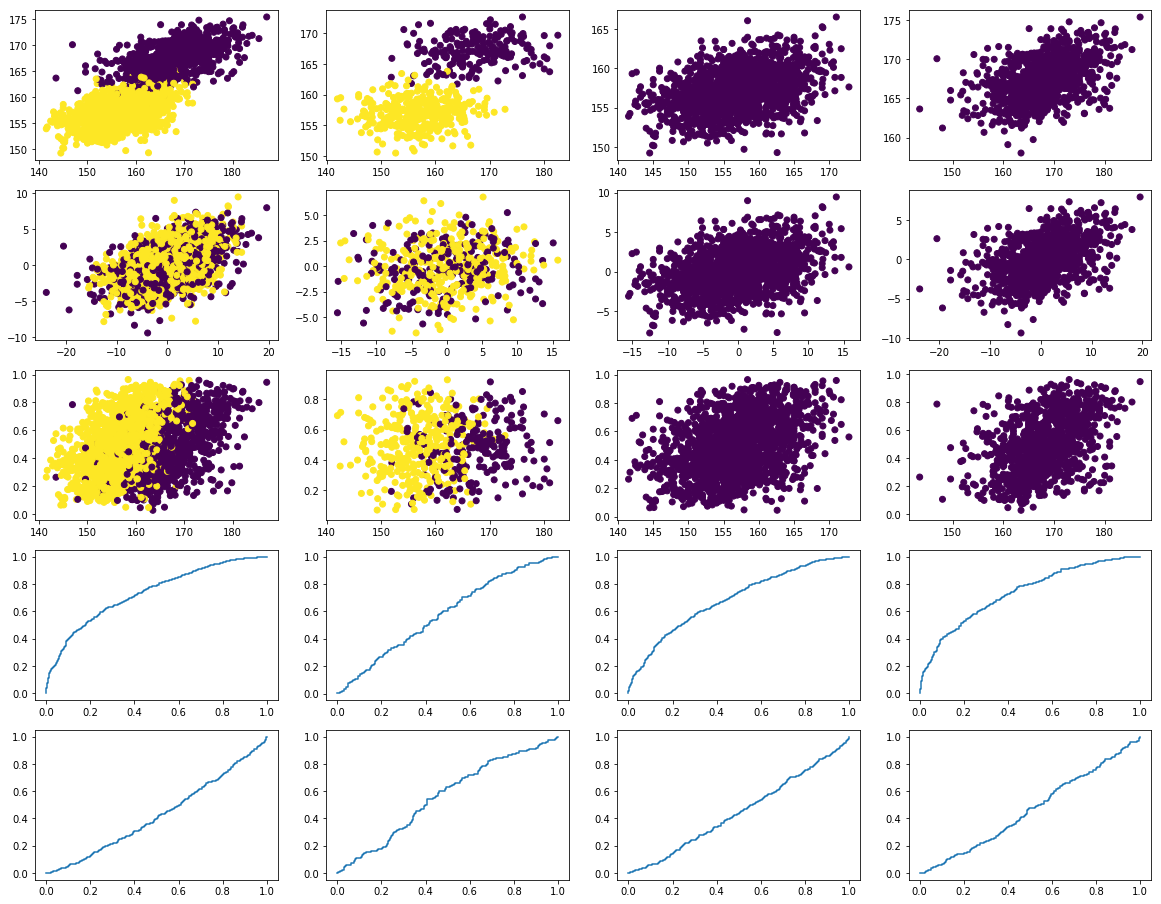

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.733100  0.425916
val     33.542486  0.429253  0.578251  0.560024
female  28.111462 -0.002415  0.685801  0.449168
male    38.206925 -0.006473  0.735556  0.462489


(         rt        rv        rf        rm        ht        hv        hf  \
 r  0.225141 -0.070521  0.136603  0.188658  0.598423  0.389003  0.136603   
 c  0.225141 -0.070521  0.136603  0.188658  0.598423  0.389003  0.136603   
 b  0.224849 -0.072914  0.136102  0.187607  0.598272  0.387638  0.136102   
 t  0.206466 -0.113684  0.112968  0.164284  0.588744  0.364368  0.112968   
 
          hm  
 r  0.188658  
 c  0.188658  
 b  0.187607  
 t  0.164284  ,
           rt         rv         rf         rm         ht         hv  \
 r  24.250150  35.907925  24.212868  30.799511  24.250150  35.907925   
 c  24.250150  35.907925  24.212868  30.799511  24.250150  35.907925   
 b  24.259269  35.988195  24.226926  30.839418  24.259269  35.988195   
 t  24.834601  37.355735  24.875693  31.724778  24.834601  37.355735   
 
           hf         hm  
 r  24.212868  30.799511  
 c  24.212868  30.799511  
 b  24.226926  30.839418  
 t  24.875693  31.724778  )

In [97]:
tmp(tz_meta,set(tts_list[0]['tz_a']+list(tz_snp.snp_x[tz_snp.snp_y.notna()])),tz_plink,val_idx=val_idx)

# Linear model (gender and nationality)

In [44]:
tz_meta=all_meta.loc[tz_plink[1].iid,]

In [45]:
regr = gn_residual(tz_meta,t=False)

50
(50, 7) (2747, 7) (2747, 50)
(2747, 28)


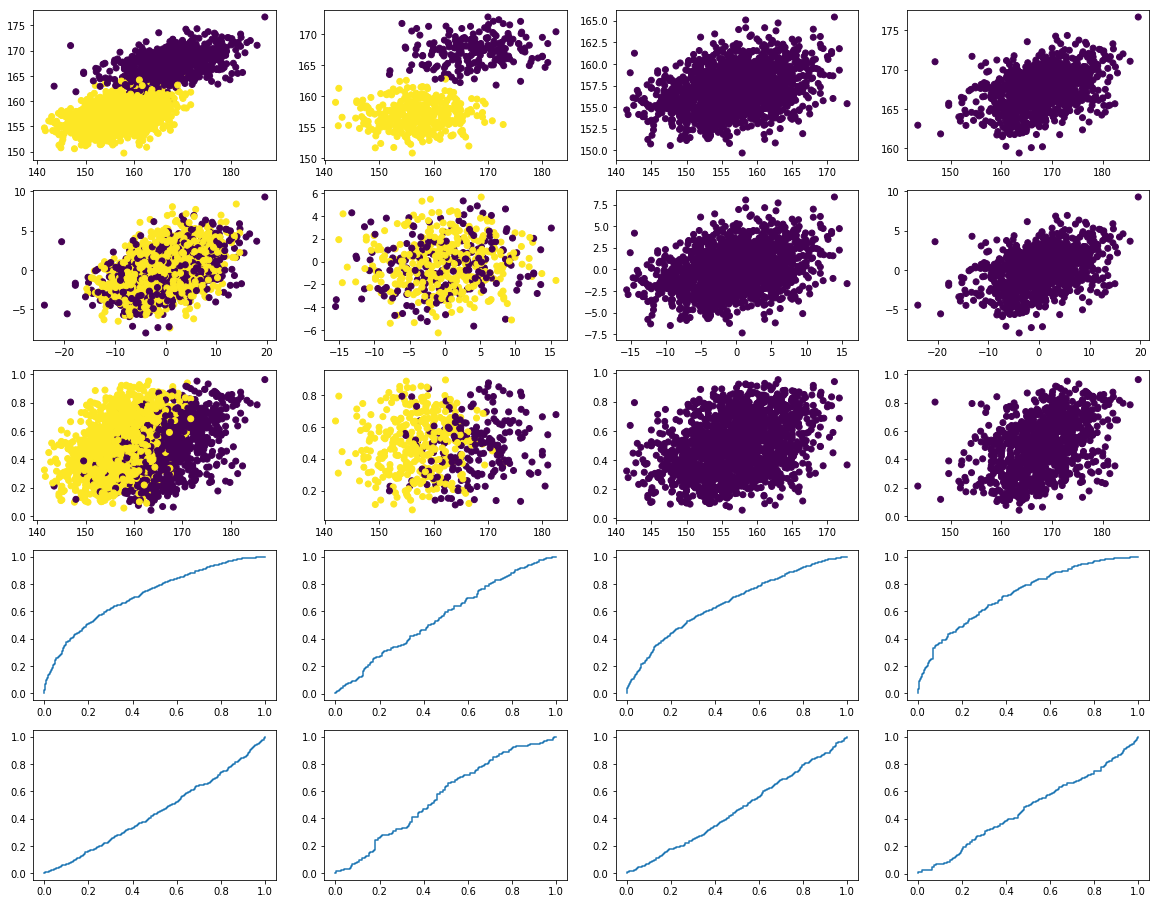

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.717510  0.445141
val     33.542486  0.429253  0.562606  0.561879
female  28.111462 -0.002415  0.664952  0.466565
male    38.206925 -0.006473  0.726301  0.471618
(140, 7) (2747, 7) (2747, 140)
(2747, 80)


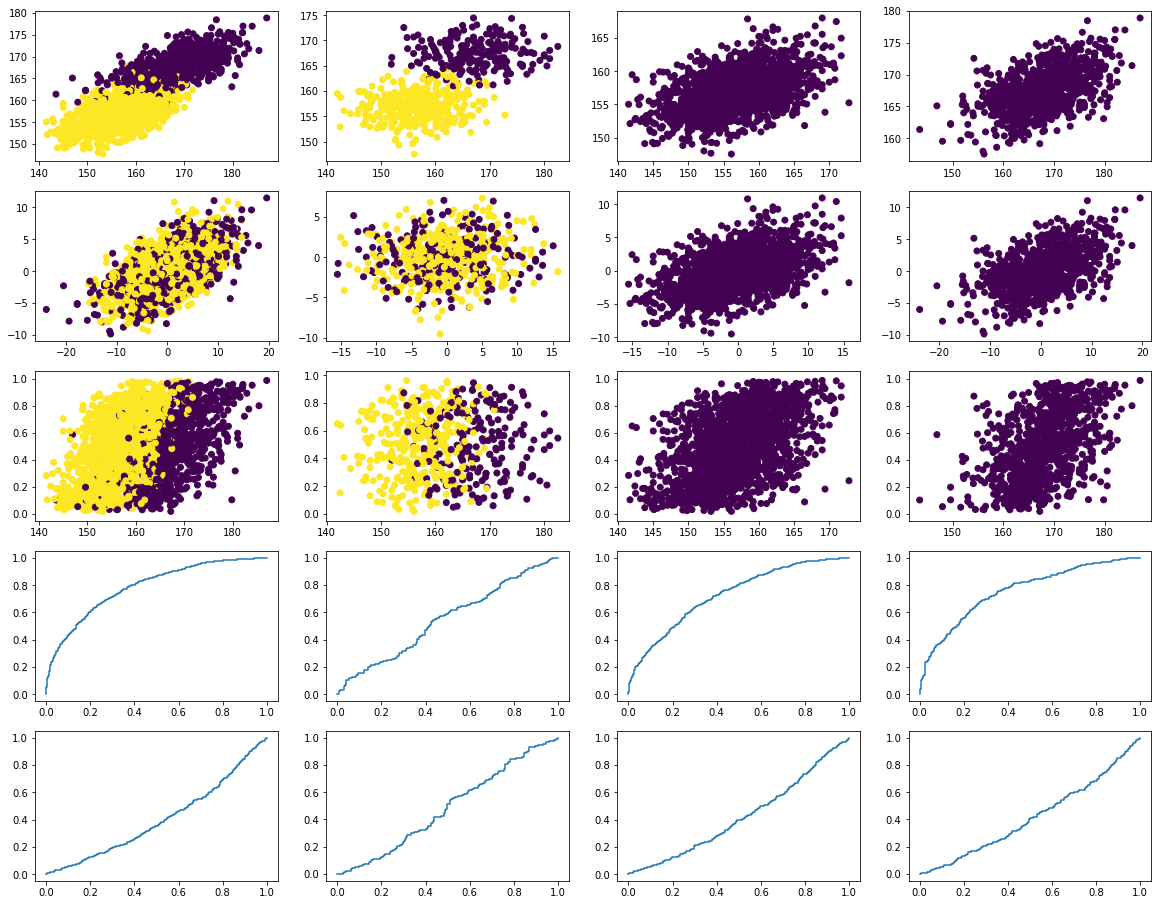

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.785483  0.402598
val     33.542486  0.429253  0.545771  0.483639
female  28.111462 -0.002415  0.729347  0.422509
male    38.206925 -0.006473  0.757721  0.416884
100
(100, 7) (2747, 7) (2747, 100)
(2747, 55)


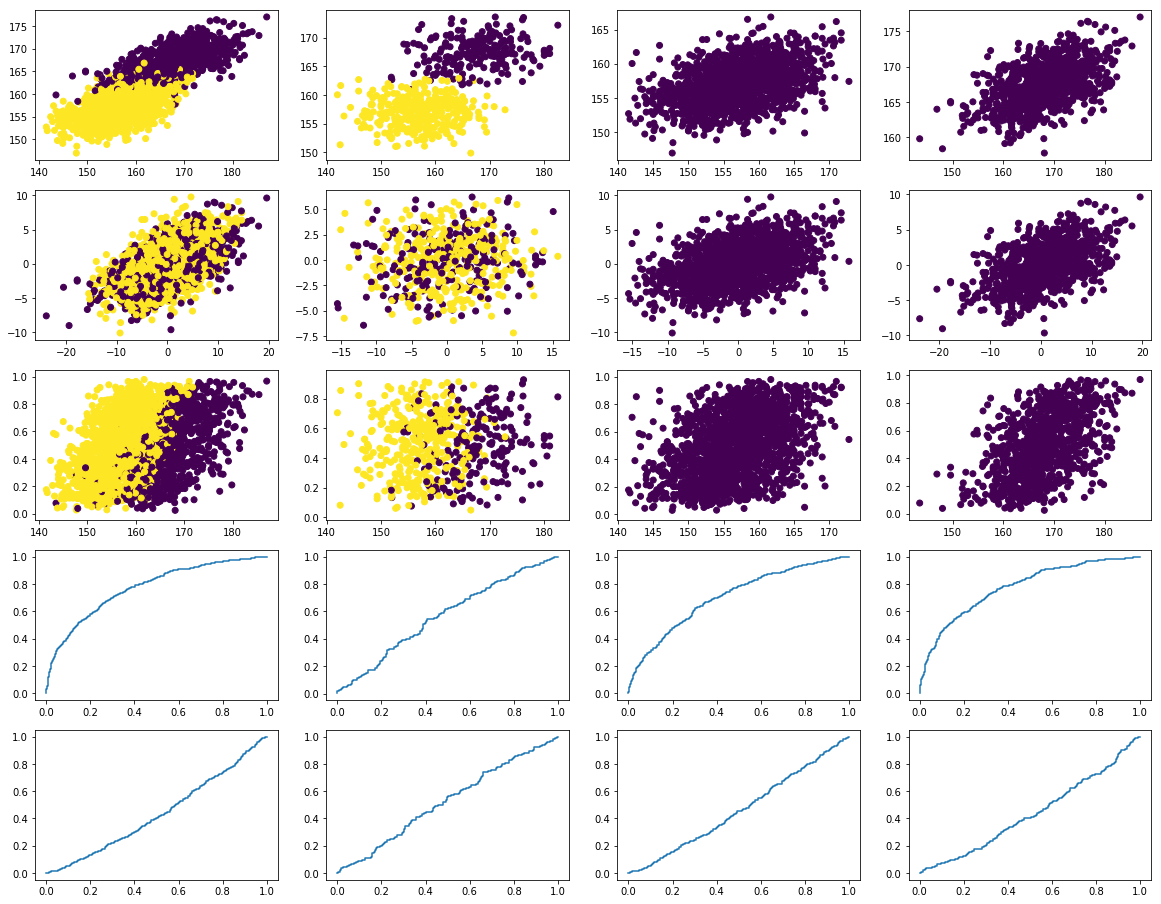

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.769670  0.435085
val     33.542486  0.429253  0.566864  0.522256
female  28.111462 -0.002415  0.706096  0.463360
male    38.206925 -0.006473  0.775261  0.435241
(275, 7) (2747, 7) (2747, 275)
(2747, 162)


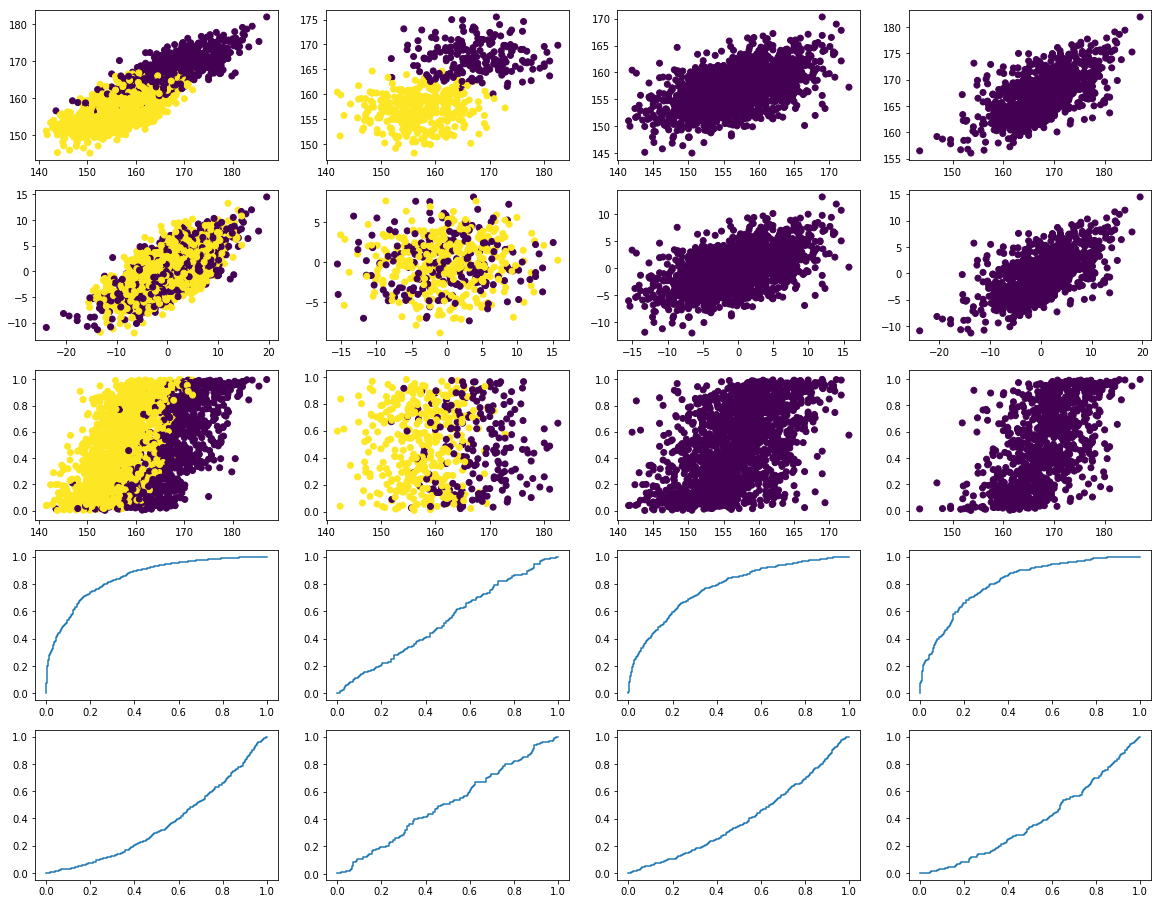

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.848099  0.363211
val     33.542486  0.429253  0.529769  0.508540
female  28.111462 -0.002415  0.776420  0.400187
male    38.206925 -0.006473  0.809866  0.382727
200
(200, 7) (2747, 7) (2747, 200)
(2747, 118)


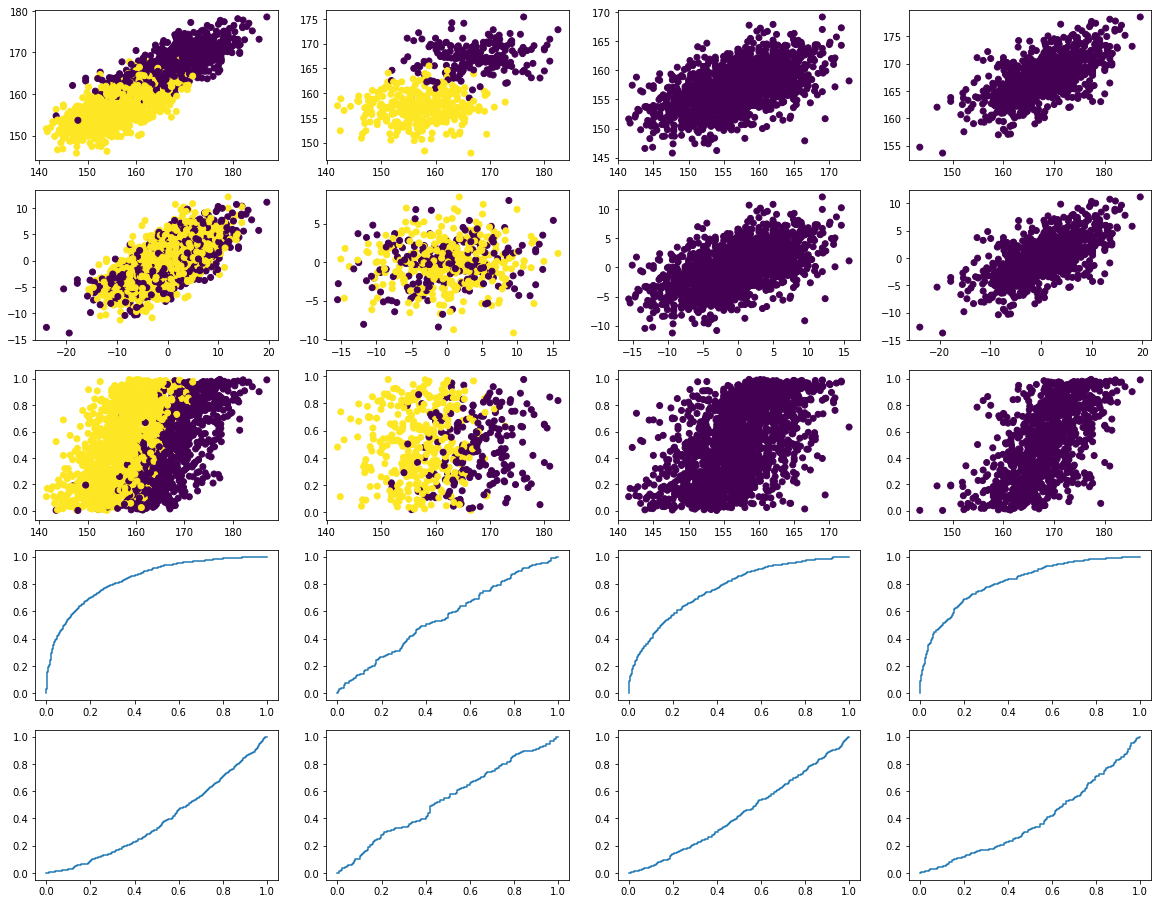

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.834773  0.387394
val     33.542486  0.429253  0.556205  0.537551
female  28.111462 -0.002415  0.768746  0.437158
male    38.206925 -0.006473  0.814160  0.387589
(543, 7) (2747, 7) (2747, 543)
(2747, 318)


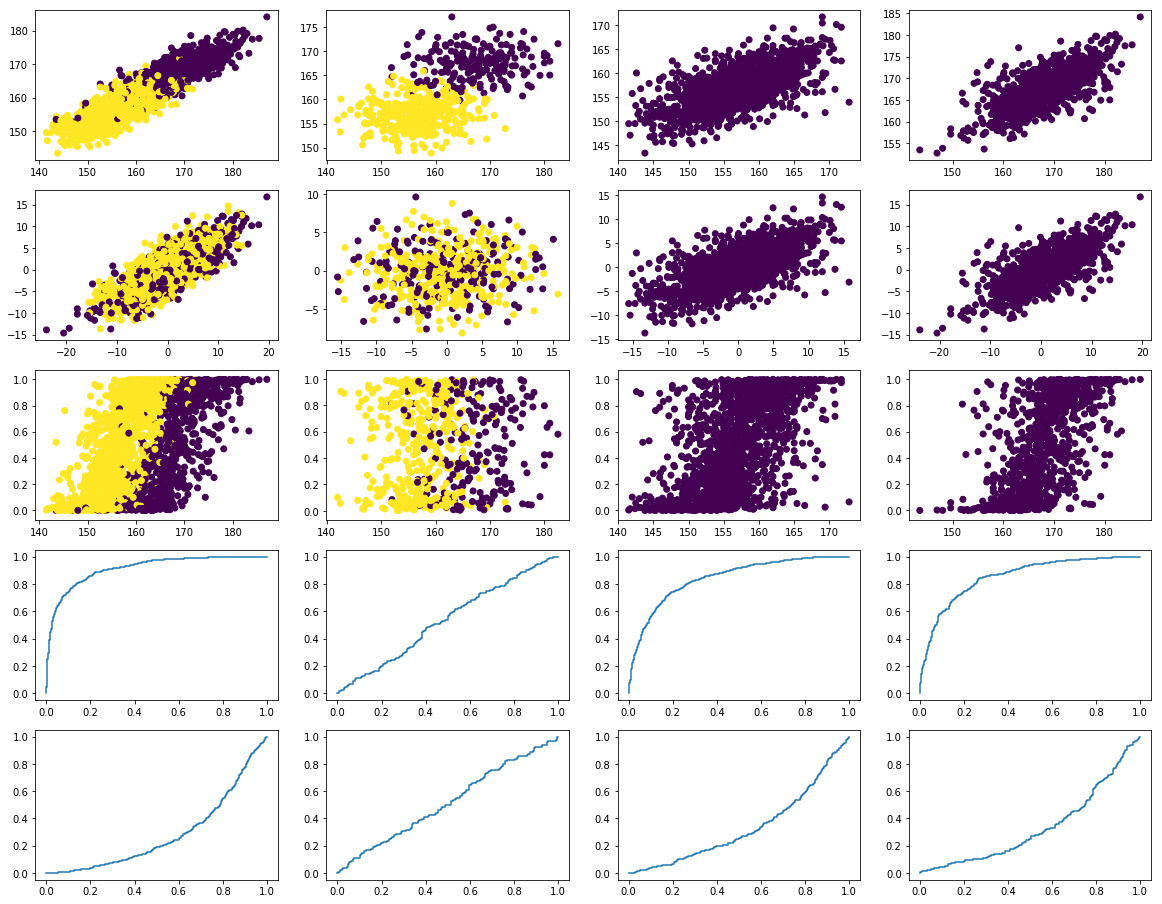

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.913011  0.284373
val     33.542486  0.429253  0.531805  0.516621
female  28.111462 -0.002415  0.841728  0.335579
male    38.206925 -0.006473  0.852724  0.336287
300
(300, 7) (2747, 7) (2747, 300)
(2747, 169)


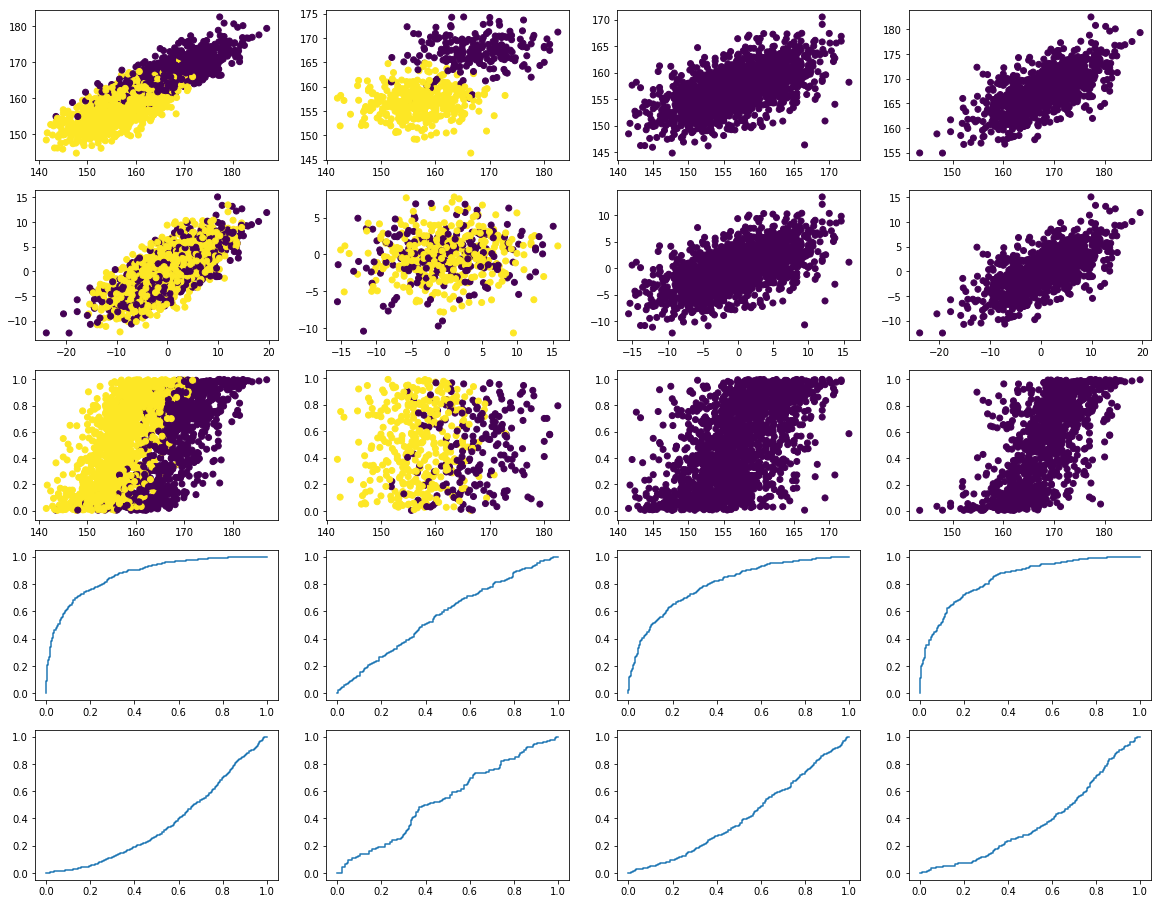

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.868014  0.361797
val     33.542486  0.429253  0.570673  0.538990
female  28.111462 -0.002415  0.800904  0.414162
male    38.206925 -0.006473  0.840415  0.375289
(807, 7) (2747, 7) (2747, 807)
(2747, 454)


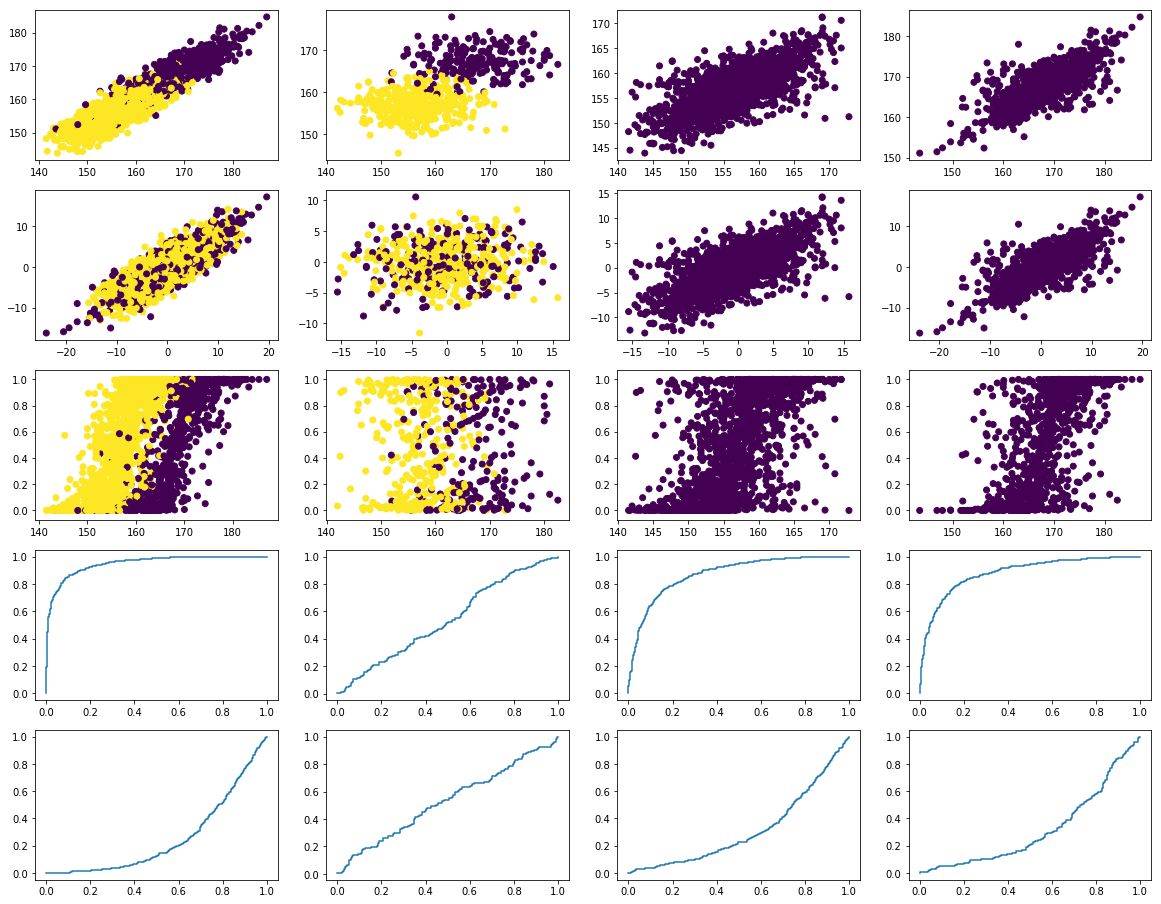

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.948755  0.255049
val     33.542486  0.429253  0.537915  0.526106
female  28.111462 -0.002415  0.873577  0.315504
male    38.206925 -0.006473  0.880615  0.319470
500
(500, 7) (2747, 7) (2747, 500)
(2747, 283)


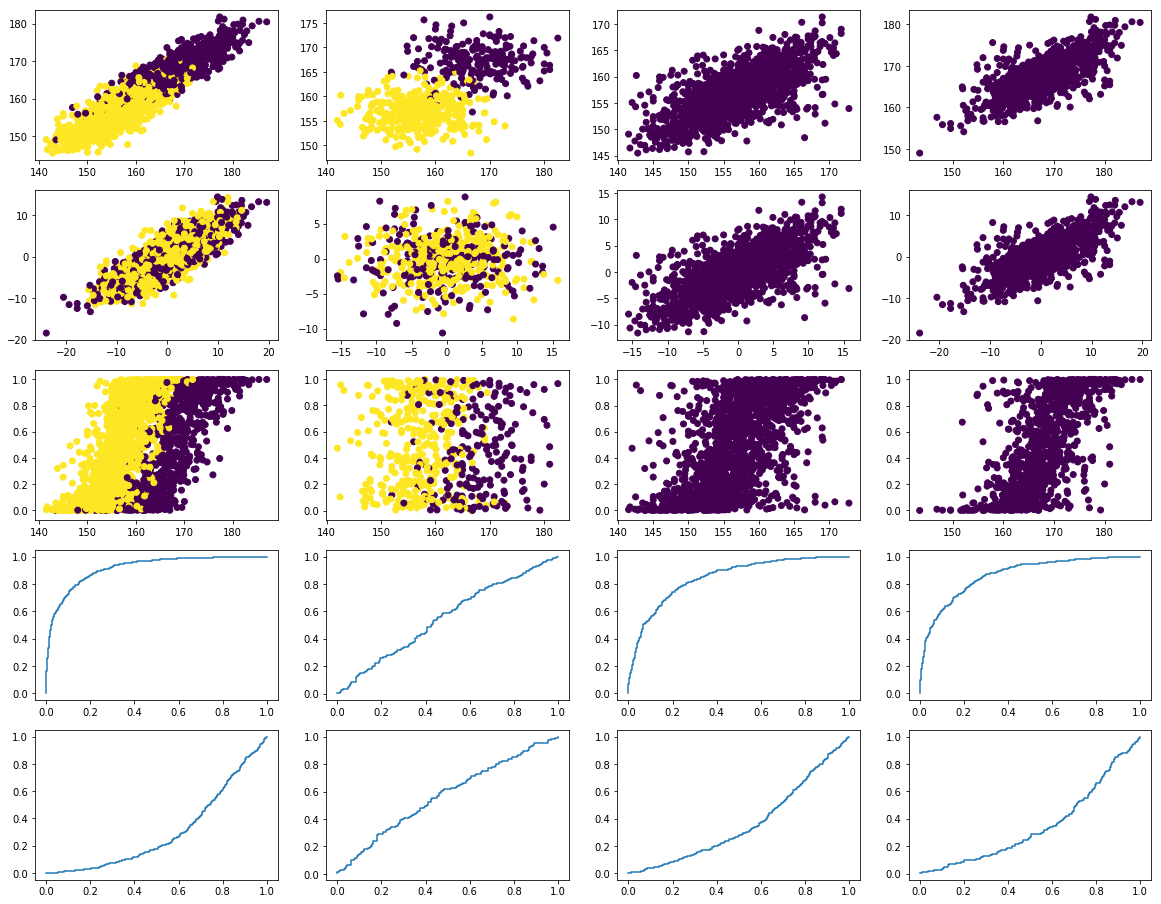

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.915249  0.302082
val     33.542486  0.429253  0.551920  0.569162
female  28.111462 -0.002415  0.846461  0.365255
male    38.206925 -0.006473  0.864960  0.348053
(1345, 7) (2747, 7) (2747, 1345)
(2747, 696)


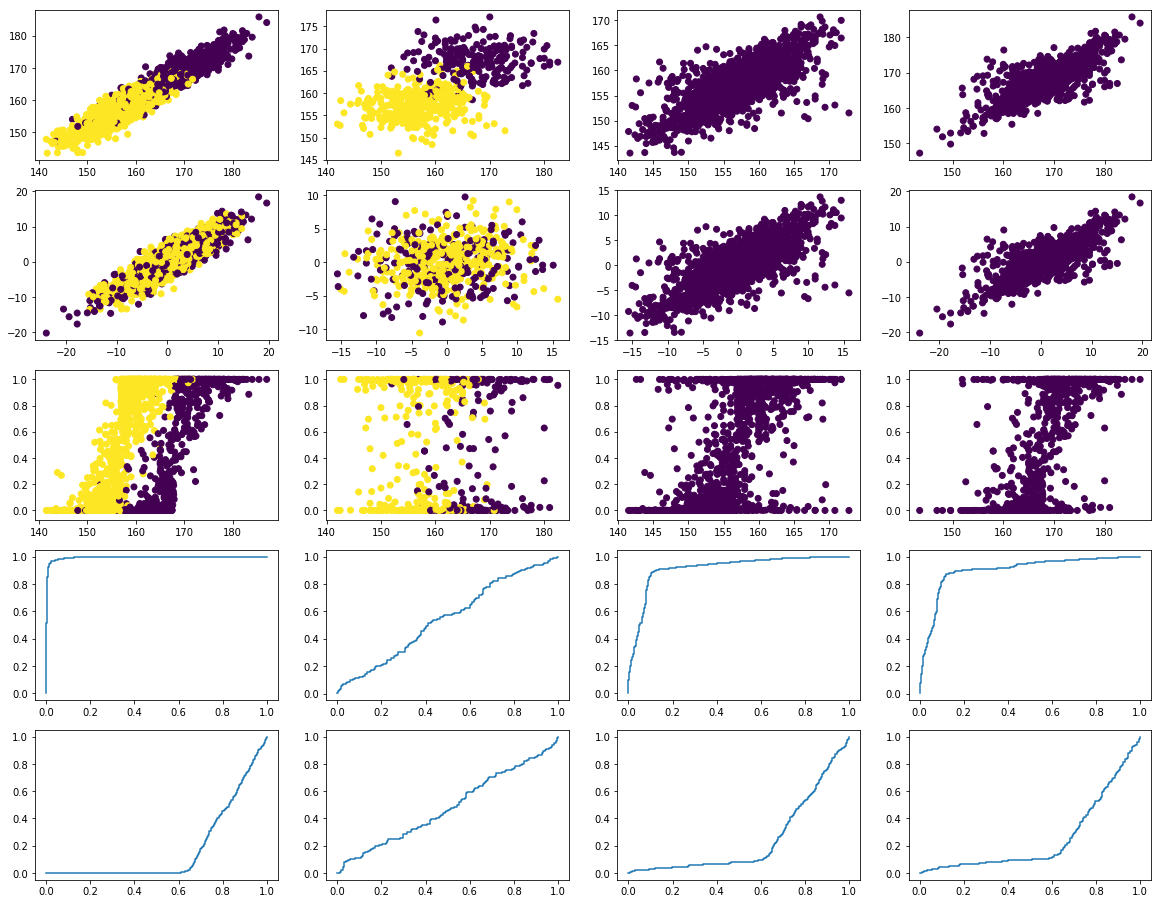

              MSE        R2     auc_b     auc_t
trn     31.296419  0.481738  0.994956  0.178454
val     33.542486  0.429253  0.546921  0.482339
female  28.111462 -0.002415  0.915512  0.244489
male    38.206925 -0.006473  0.899345  0.251063


In [49]:
results={}
for i,snp in zip([50,100,200,300,500],tts_list):
    print(i)
    results[i]=[tmp(tz_meta,s,tz_plink,val_idx) for s in [snp['tz_a'],set(snp['tz_a']+snp['tz_f']+snp['tz_m'])]]

In [50]:
results

{50: [(         rt        rv        rf        rm        ht        hv        hf  \
   r  0.192755 -0.080750  0.105894  0.164646  0.581638  0.383165  0.105894   
   c  0.192755 -0.080750  0.105894  0.164646  0.581638  0.383165  0.105894   
   b  0.192599 -0.081503  0.105376  0.164671  0.581558  0.382735  0.105376   
   t  0.184766 -0.104428  0.088441  0.161299  0.577498  0.369651  0.088441   
   
            hm  
   r  0.164646  
   c  0.164646  
   b  0.164671  
   t  0.161299  ,
             rt         rv         rf         rm         ht         hv  \
   r  25.263713  36.251026  25.074064  31.711058  25.263713  36.251026   
   c  25.263713  36.251026  25.074064  31.711058  25.263713  36.251026   
   b  25.268583  36.276309  25.088599  31.710101  25.268583  36.276309   
   t  25.513731  37.045271  25.563515  31.838127  25.513731  37.045271   
   
             hf         hm  
   r  25.074064  31.711058  
   c  25.074064  31.711058  
   b  25.088599  31.710101  
   t  25.563515  31.838127

(200, 7) (2747, 7) (2747, 200)
2747 2197
(2747, 110)


/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


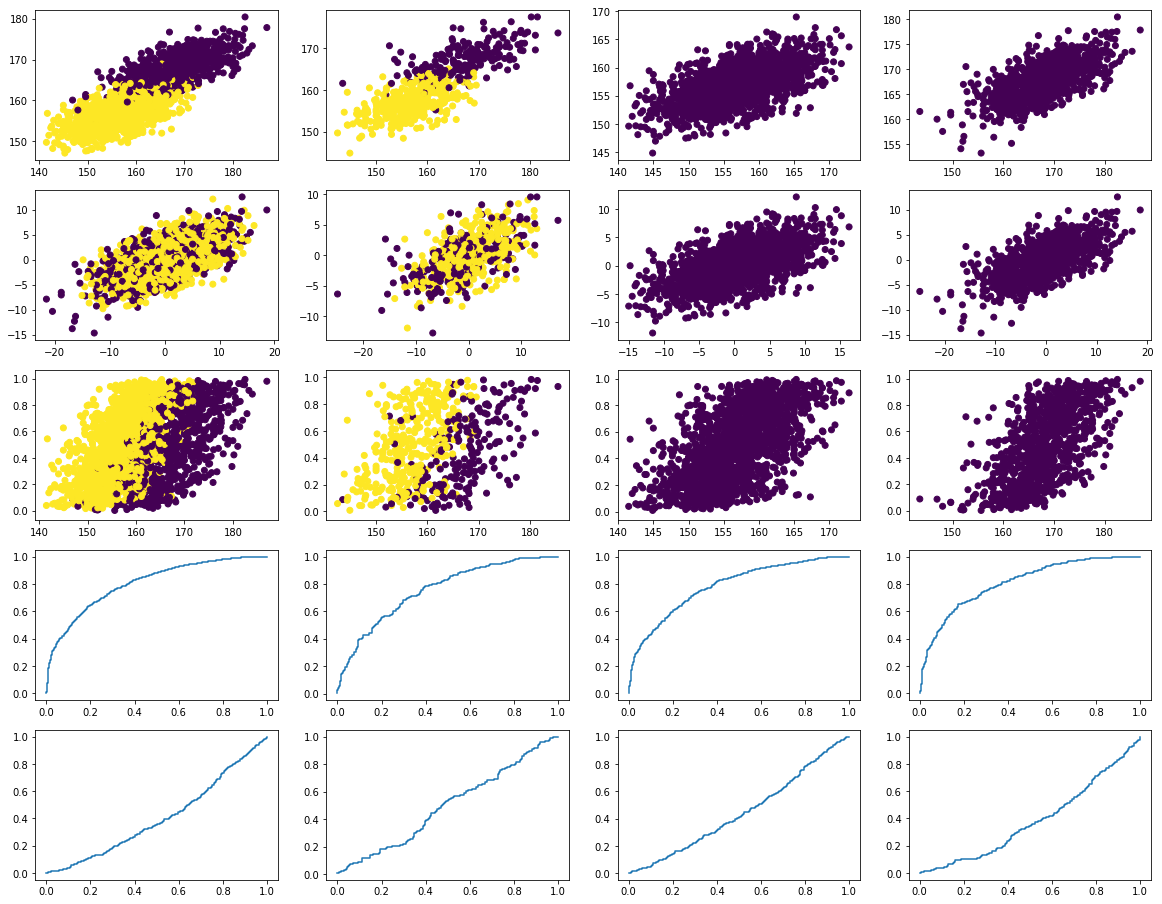

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.804324  0.405126
val     34.328853  0.432136  0.754395  0.492709
female  28.043737  0.000000  0.784712  0.445551
male    37.961214  0.000000  0.809433  0.384835


(         rt        rv        rf        rm        ht        hv        hf  \
 r  0.382623  0.322647  0.330356  0.415228  0.682708  0.614341  0.332897   
 c  0.382623  0.322647  0.330356  0.415228  0.682708  0.614341  0.332897   
 b  0.381741  0.320420  0.330307  0.412563  0.682191  0.613070  0.333028   
 t  0.375819  0.309053  0.322234  0.406650  0.679487  0.606083  0.325909   
 
          hm  
 r  0.420878  
 c  0.420878  
 b  0.417766  
 t  0.411435  ,
           rt         rv         rf         rm         ht         hv  \
 r  19.148389  23.453634  18.779326  22.198639  19.029759  23.314052   
 c  19.148389  23.453634  18.779326  22.198639  19.029759  23.314052   
 b  19.175728  23.530738  18.780684  22.299837  19.060766  23.390897   
 t  19.359393  23.924341  19.007094  22.524268  19.222970  23.813293   
 
           hf         hm  
 r  18.708060  21.984167  
 c  18.708060  21.984167  
 b  18.704387  22.102310  
 t  18.904035  22.342653  )

In [46]:
tmp(tz_meta,snp_list[2]['tz_a'],tz_plink,ml=linear_model.HuberRegressor())

(200, 7) (2747, 7) (2747, 200)
2747 2197
(2747, 134)


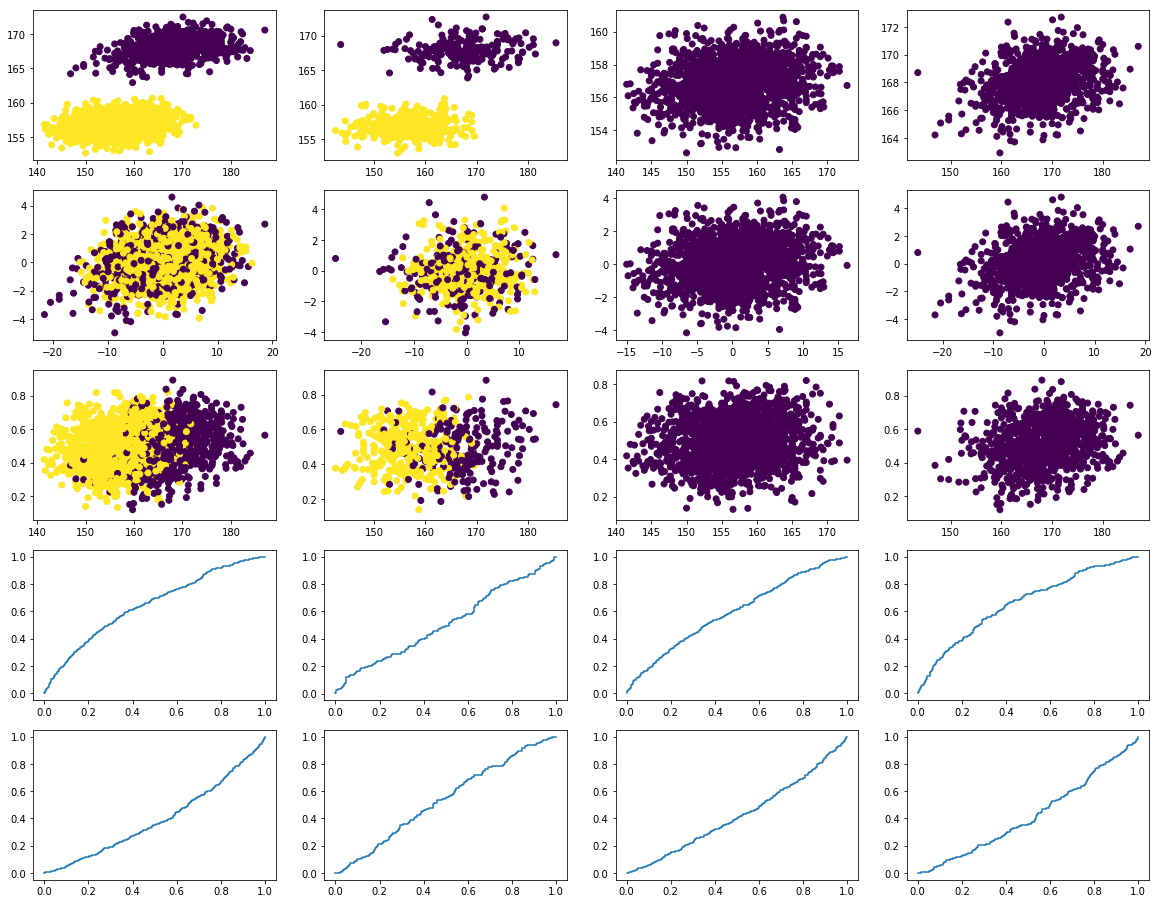

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.644103  0.394067
val     34.328853  0.432136  0.513673  0.537118
female  28.043737  0.000000  0.594220  0.425512
male    37.961214  0.000000  0.656170  0.421434


(         rt        rv        rf        rm        ht        hv        hf  \
 r  0.059704 -0.025089  0.018502  0.062259  0.515447  0.418188  0.020618   
 c  0.059704 -0.025089  0.018502  0.062259  0.515447  0.418188  0.020618   
 b  0.054759 -0.020940  0.014367  0.060818  0.513151  0.420656  0.017074   
 t  0.013697 -0.092057 -0.047252  0.031132  0.491958  0.380760 -0.044535   
 
          hm  
 r  0.070202  
 c  0.070202  
 b  0.068982  
 t  0.040174  ,
           rt         rv         rf         rm         ht         hv  \
 r  29.163937  35.494148  27.524875  35.597796  29.061352  35.172044   
 c  29.163937  35.494148  27.524875  35.597796  29.061352  35.172044   
 b  29.317316  35.350475  27.640846  35.652475  29.199087  35.022816   
 t  30.590876  37.812946  29.368854  36.779403  30.470108  37.434621   
 
           hf         hm  
 r  27.465526  35.296279  
 c  27.465526  35.296279  
 b  27.564919  35.342582  
 t  29.292670  36.436152  )

In [48]:
snp = set(snp_list[2]['os_a'])
tmp(tz_meta,snp,tz_plink)

(200, 7) (2747, 7) (2747, 200)
2747 2197
(2747, 68)


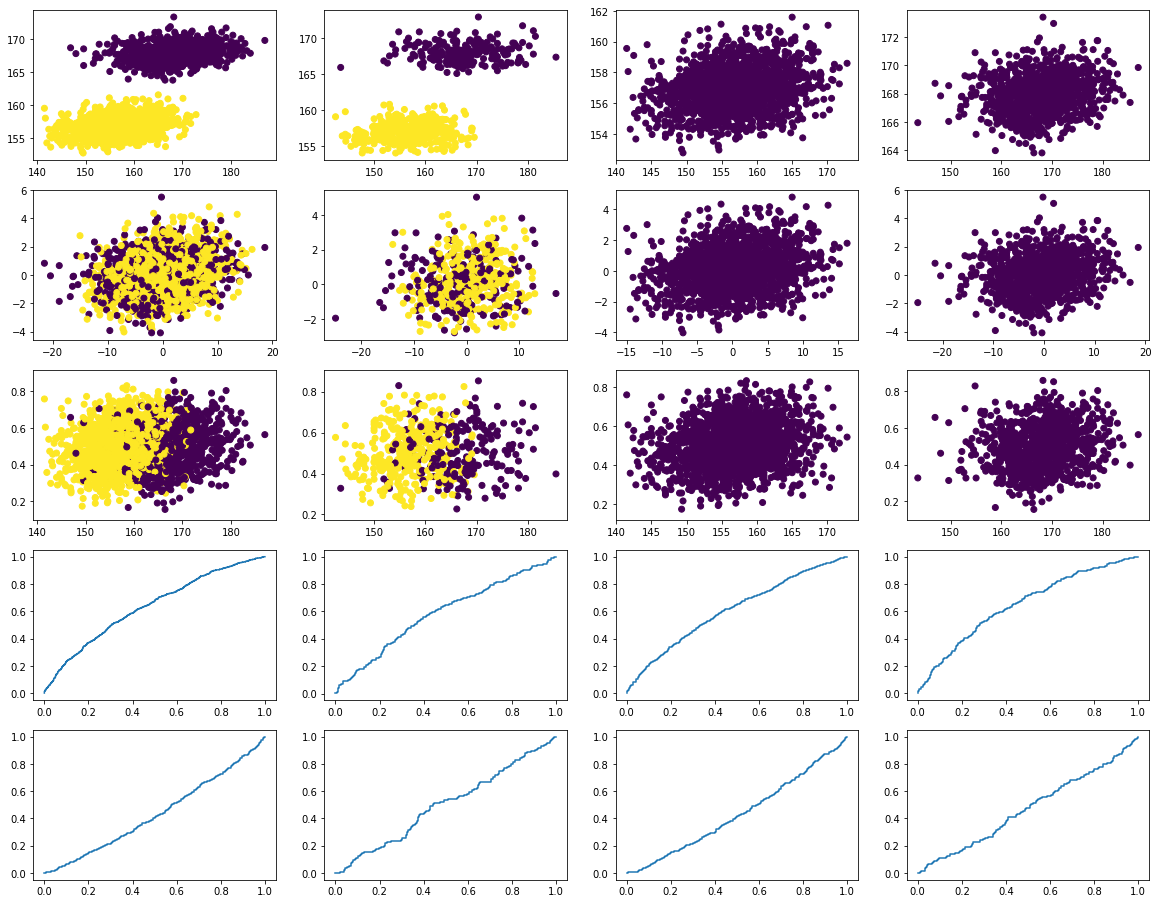

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.632363  0.434660
val     34.328853  0.432136  0.584331  0.498206
female  28.043737  0.000000  0.608187  0.434464
male    37.961214  0.000000  0.648073  0.471495


(         rt        rv        rf        rm        ht        hv        hf  \
 r  0.059530 -0.021008  0.045245  0.028895  0.514718  0.420455  0.046123   
 c  0.059530 -0.021008  0.045245  0.028895  0.514718  0.420455  0.046123   
 b  0.059998 -0.017021  0.045470  0.031472  0.514912  0.422813  0.046690   
 t  0.036199 -0.055627  0.015953  0.007454  0.502757  0.401015  0.017206   
 
          hm  
 r  0.036158  
 c  0.036158  
 b  0.038184  
 t  0.014935  ,
           rt         rv         rf         rm         ht         hv  \
 r  29.169336  35.352828  26.774893  36.864332  29.105093  35.034984   
 c  29.169336  35.352828  26.774893  36.864332  29.105093  35.034984   
 b  29.154811  35.214770  26.768595  36.766483  29.093430  34.892420   
 t  29.892973  36.551513  27.596352  37.678268  29.822470  36.210174   
 
           hf         hm  
 r  26.750284  36.588606  
 c  26.750284  36.588606  
 b  26.734375  36.511694  
 t  27.561228  37.394260  )

In [55]:
snp = set(snp_list[2]['other'])
#snp.remove('rs34539857')
tmp(tz_meta,snp,tz_plink)

In [57]:
from sklearn.ensemble import RandomForestRegressor

50
(50, 7) (2747, 7) (2747, 50)
2747 2197
(2747, 26)


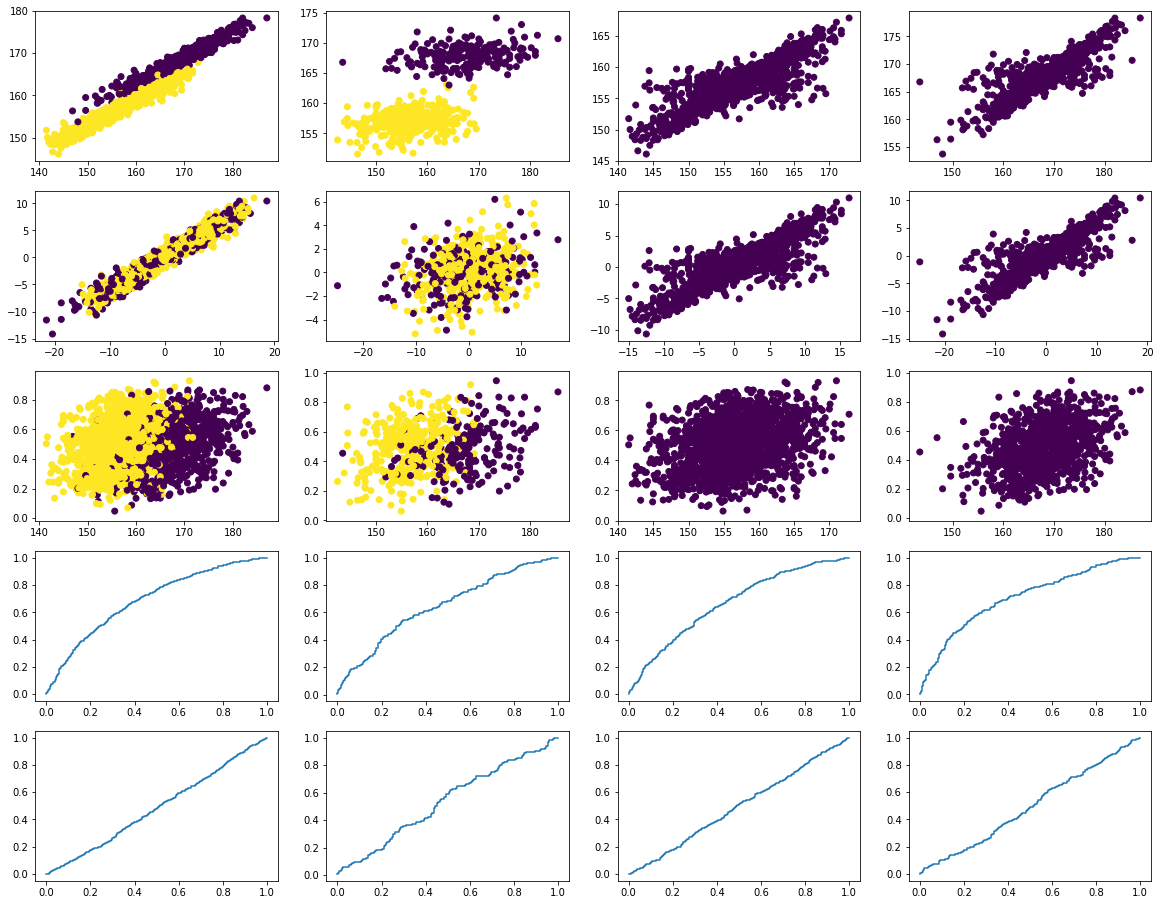

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.688923  0.483514
val     34.328853  0.432136  0.644843  0.533809
female  28.043737  0.000000  0.666160  0.493754
male    37.961214  0.000000  0.705637  0.493002
(141, 7) (2747, 7) (2747, 141)
2747 2197
(2747, 86)


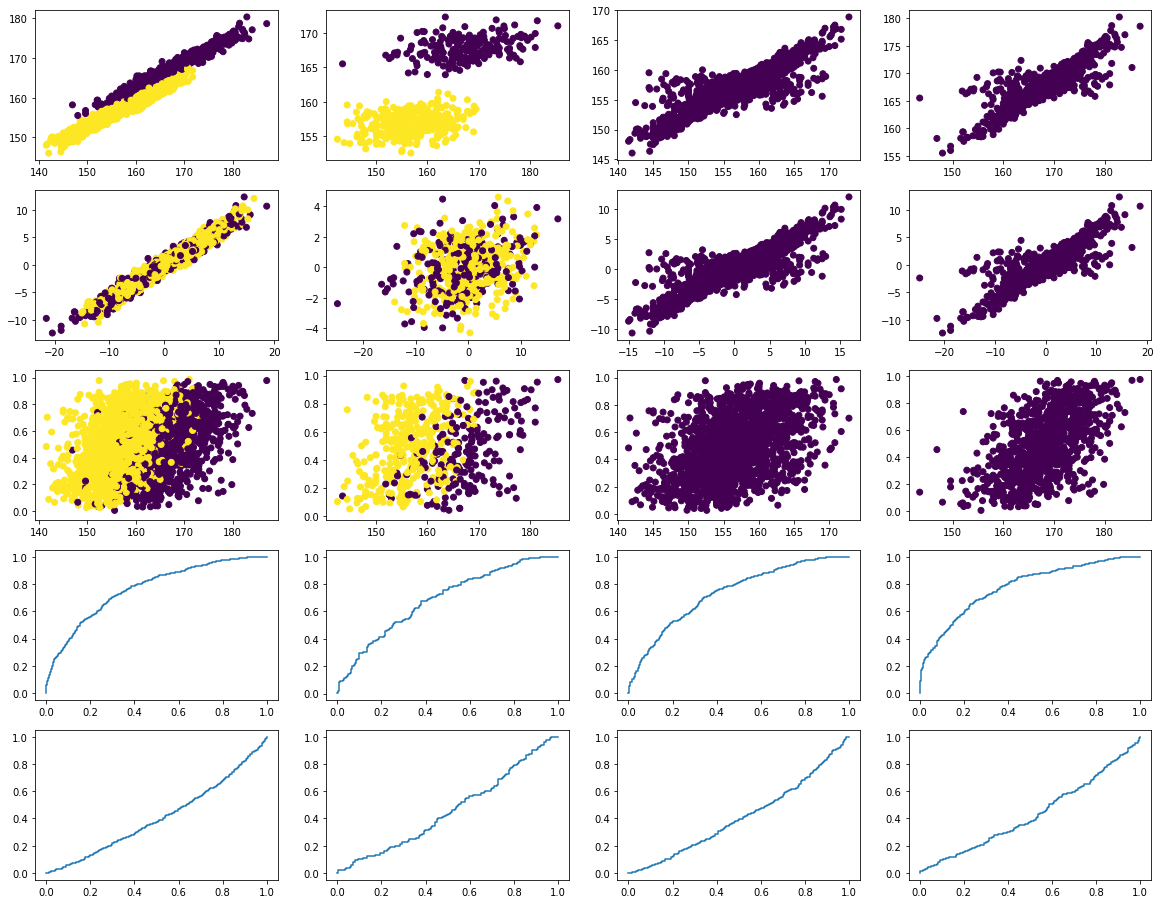

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.764935  0.407887
val     34.328853  0.432136  0.685602  0.457193
female  28.043737  0.000000  0.732731  0.411242
male    37.961214  0.000000  0.776201  0.430201
100
(100, 7) (2747, 7) (2747, 100)
2747 2197
(2747, 56)


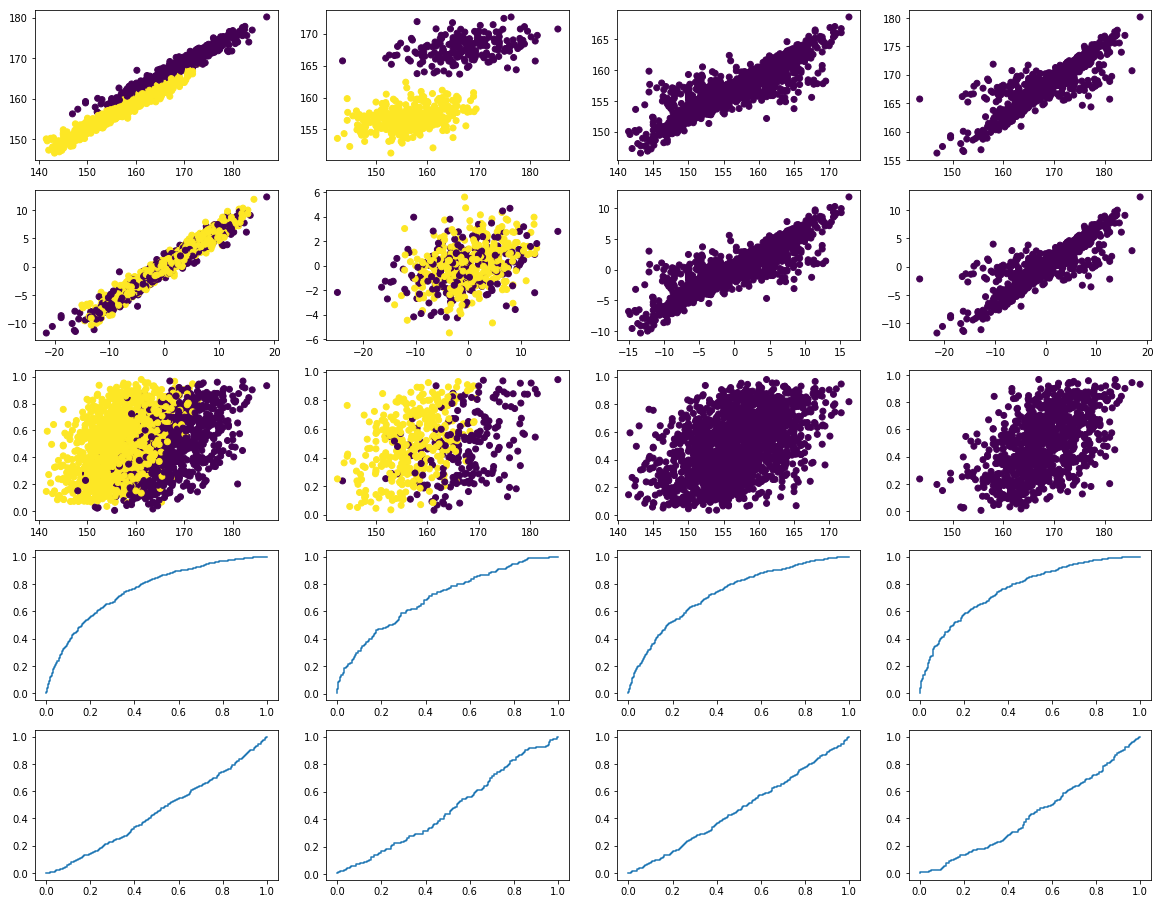

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.754883  0.445981
val     34.328853  0.432136  0.700419  0.473507
female  28.043737  0.000000  0.733327  0.466091
male    37.961214  0.000000  0.763054  0.426074
(270, 7) (2747, 7) (2747, 270)
2747 2197
(2747, 162)


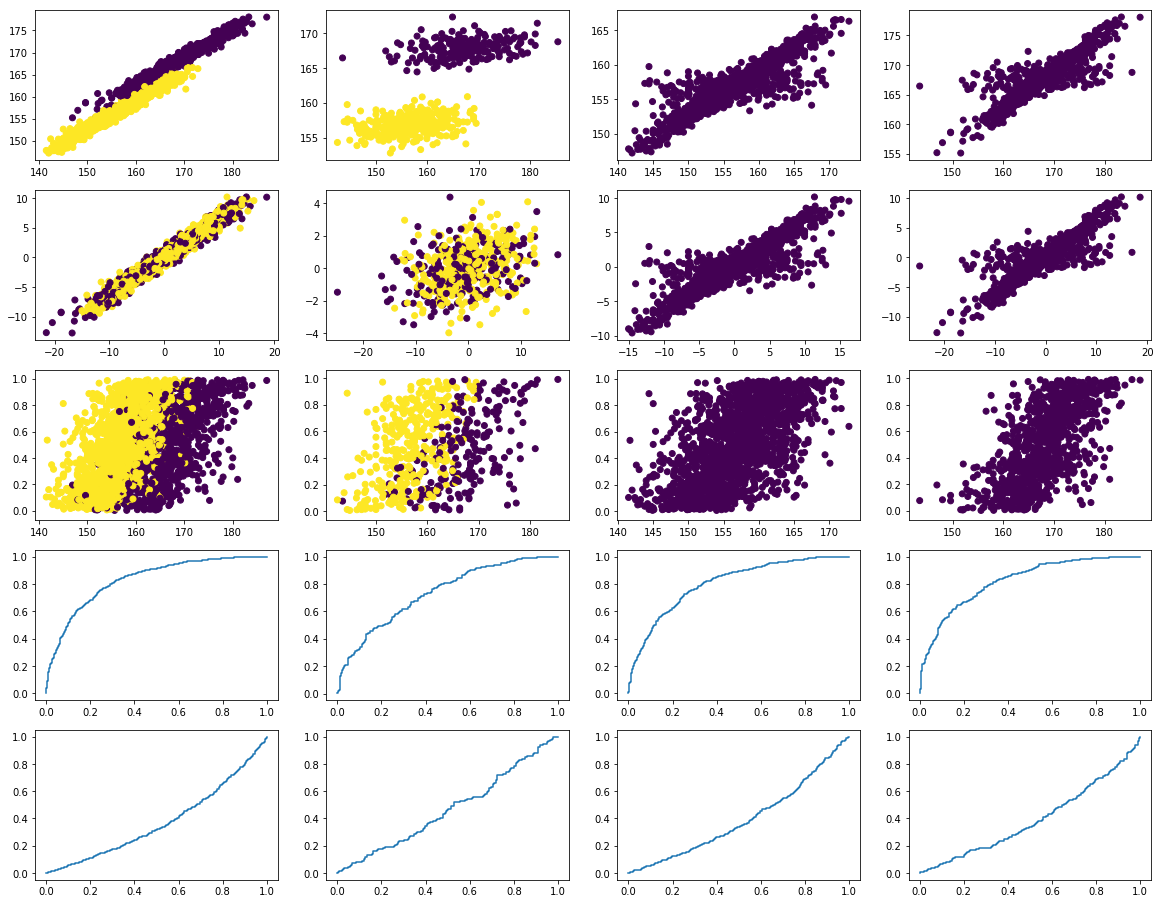

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.828789  0.374929
val     34.328853  0.432136  0.734366  0.465263
female  28.043737  0.000000  0.803938  0.394006
male    37.961214  0.000000  0.821272  0.391605
200
(200, 7) (2747, 7) (2747, 200)
2747 2197
(2747, 110)


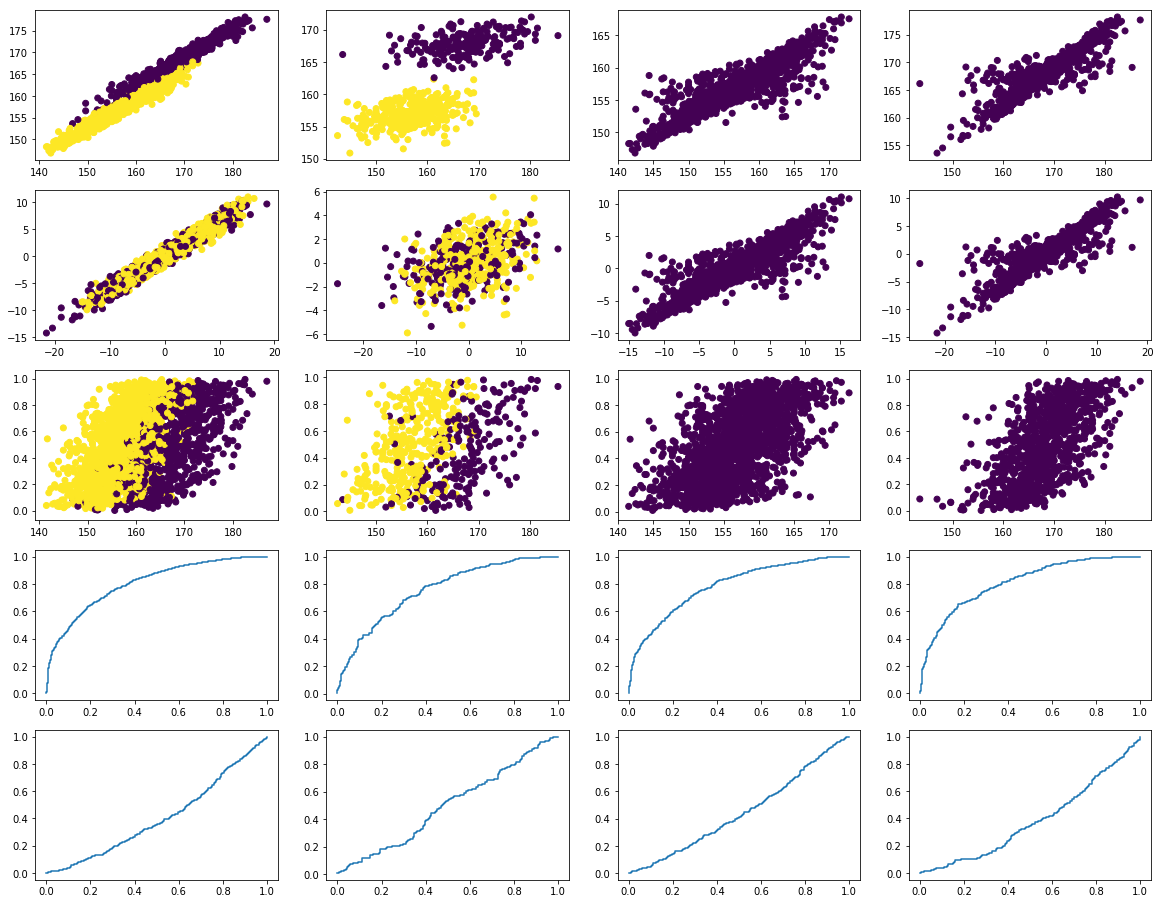

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.804324  0.405126
val     34.328853  0.432136  0.754395  0.492709
female  28.043737  0.000000  0.784712  0.445551
male    37.961214  0.000000  0.809433  0.384835
(542, 7) (2747, 7) (2747, 542)
2747 2197
(2747, 313)


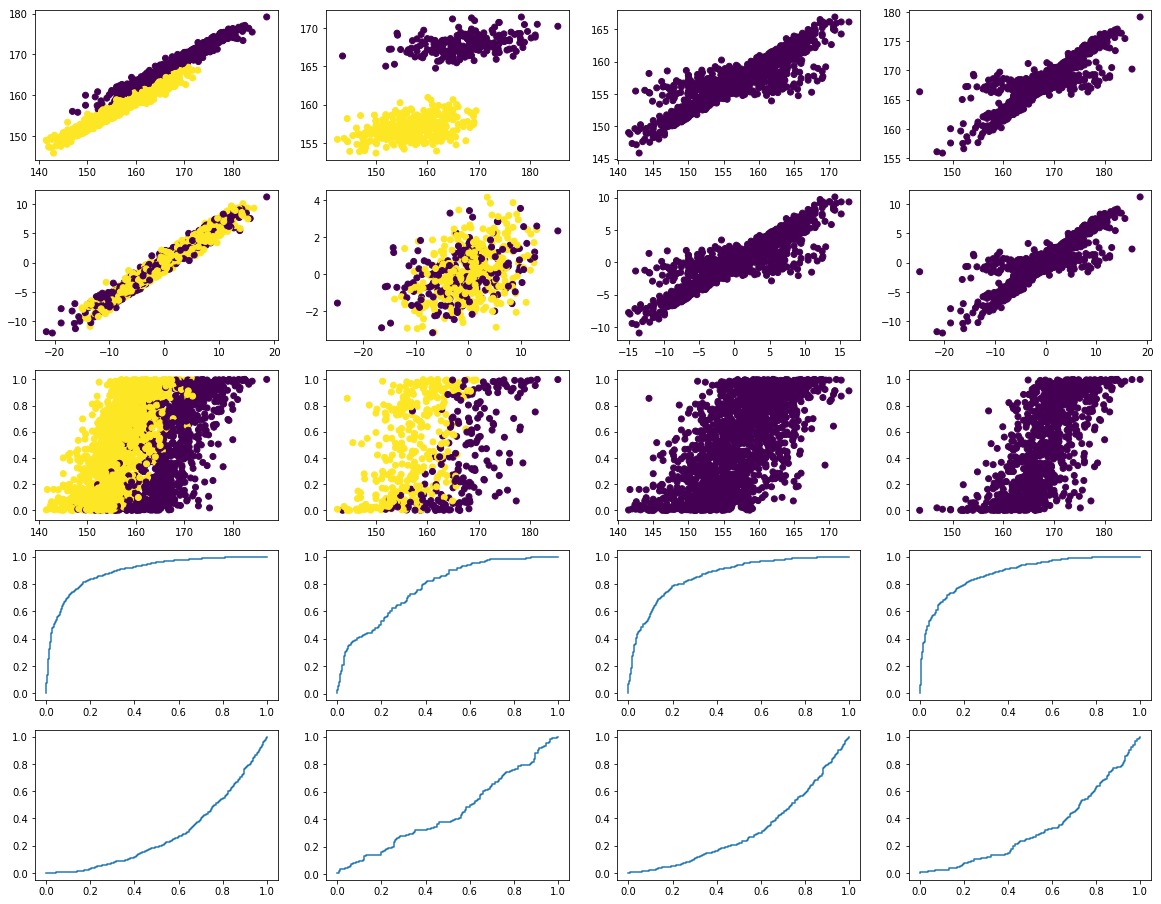

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.892712  0.284624
val     34.328853  0.432136  0.776833  0.449894
female  28.043737  0.000000  0.860822  0.315536
male    37.961214  0.000000  0.880333  0.327553
300
(300, 7) (2747, 7) (2747, 300)
2747 2197
(2747, 158)


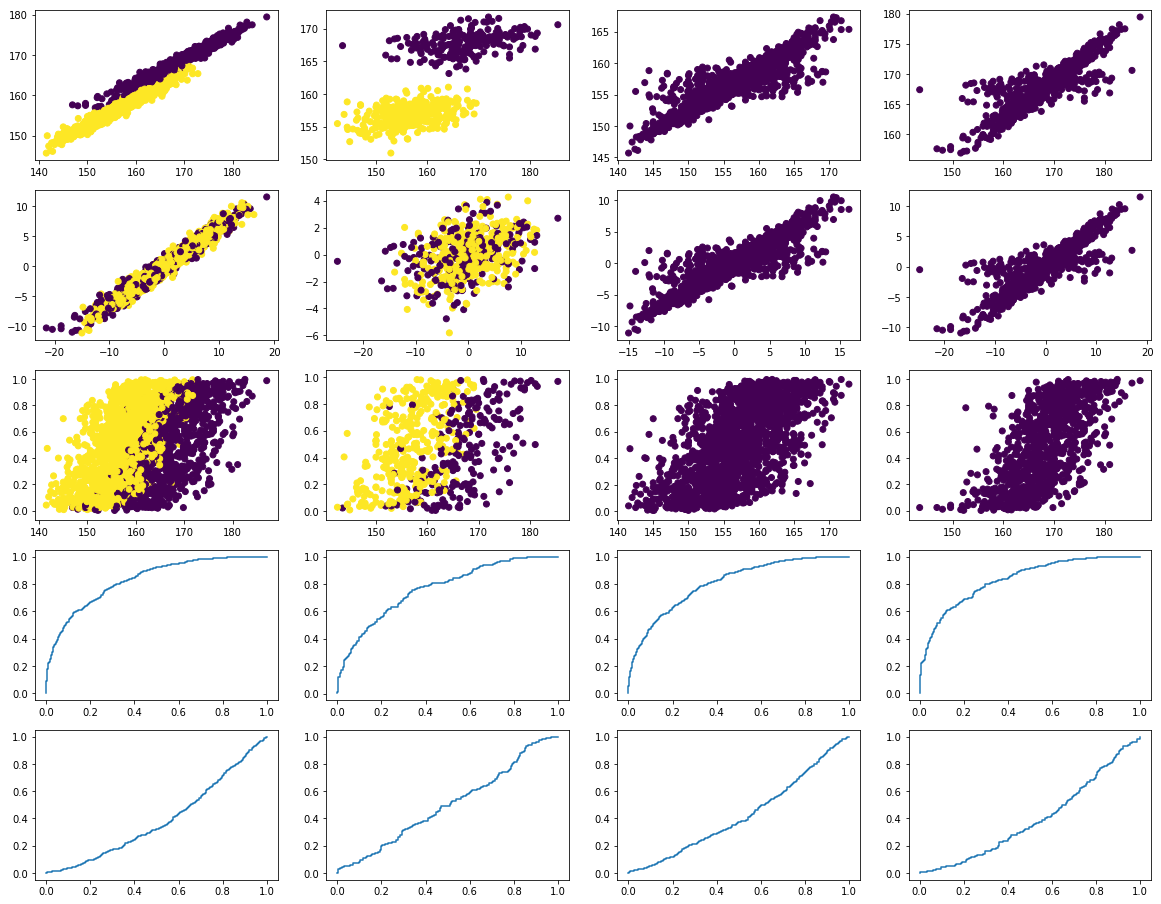

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.828847  0.390364
val     34.328853  0.432136  0.766262  0.499221
female  28.043737  0.000000  0.806523  0.424368
male    37.961214  0.000000  0.832383  0.393107
(808, 7) (2747, 7) (2747, 808)
2747 2197
(2747, 447)


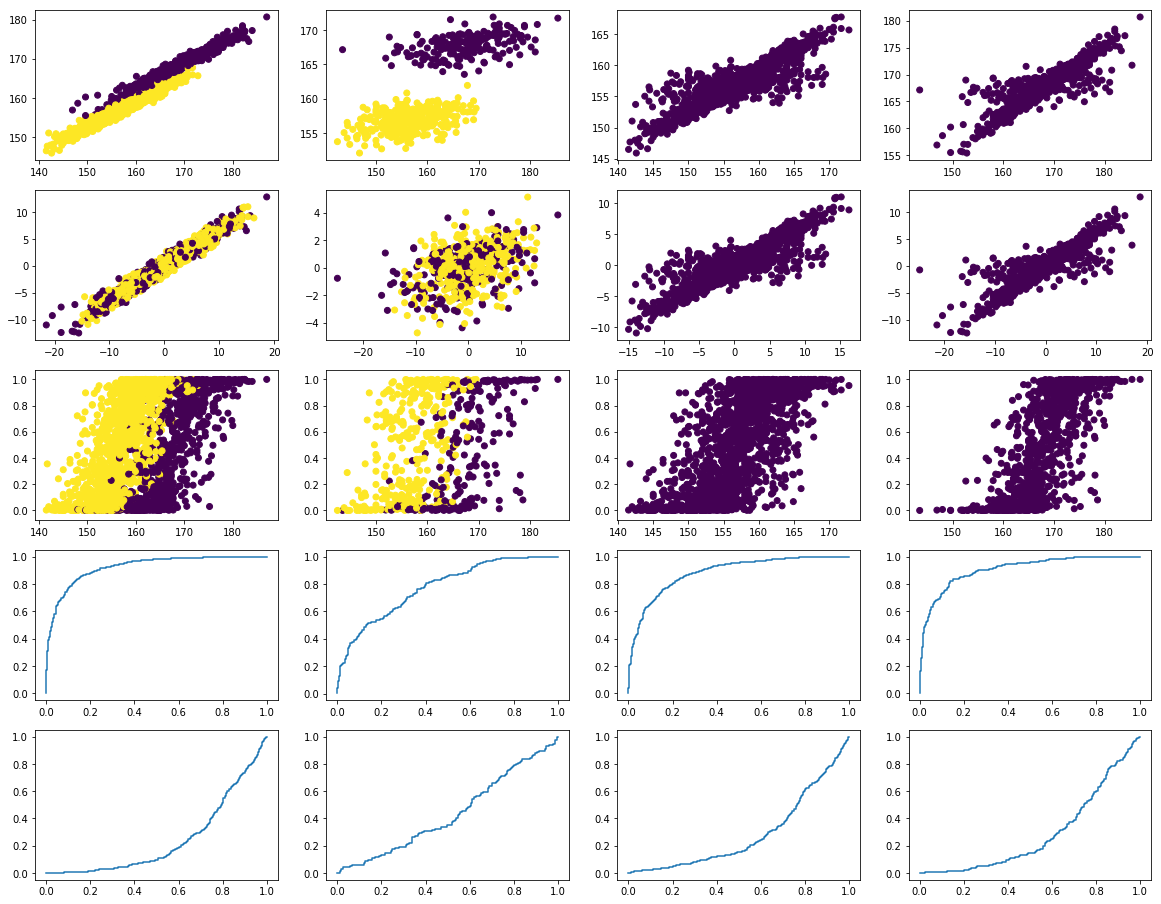

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.923388  0.245233
val     34.328853  0.432136  0.775867  0.433388
female  28.043737  0.000000  0.883760  0.285631
male    37.961214  0.000000  0.907782  0.288001
500
(500, 7) (2747, 7) (2747, 500)
2747 2197
(2747, 261)


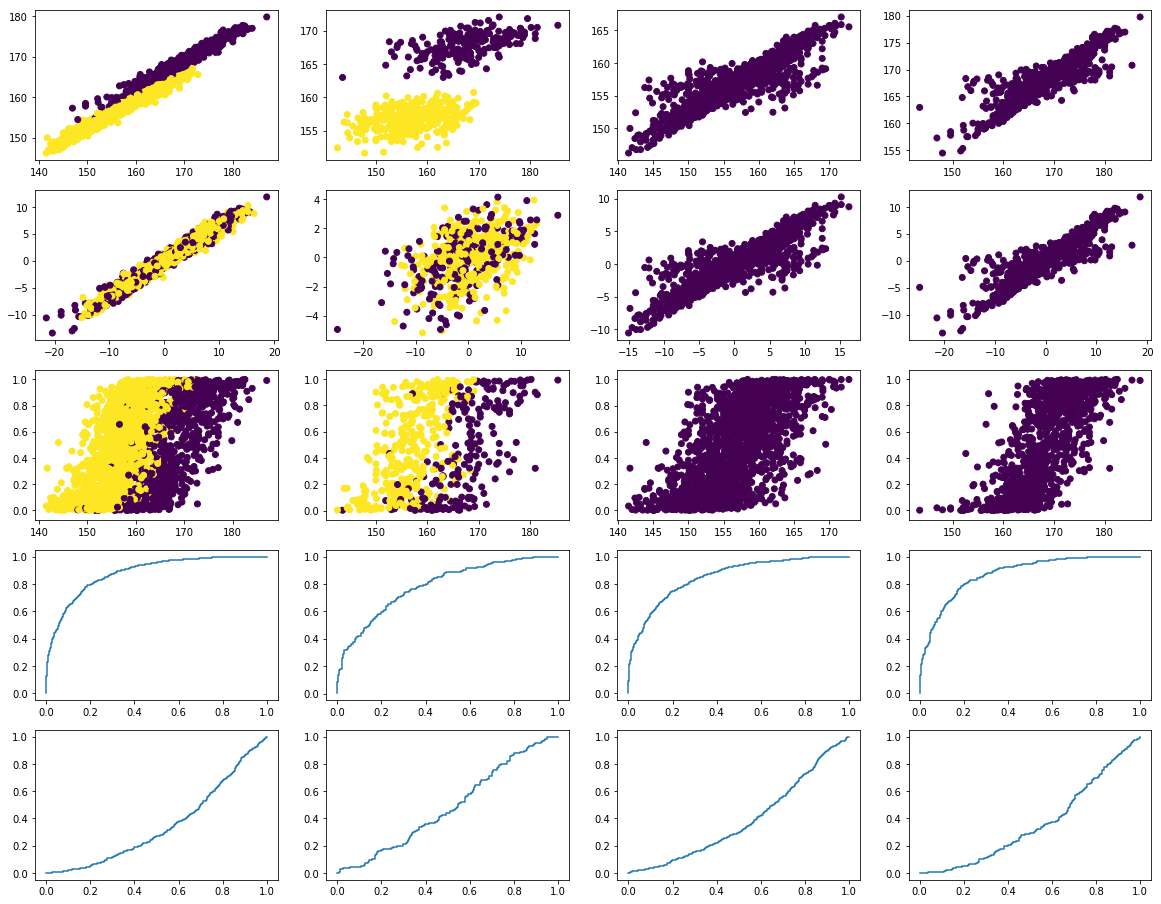

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.880365  0.350942
val     34.328853  0.432136  0.786966  0.484010
female  28.043737  0.000000  0.854008  0.388560
male    37.961214  0.000000  0.872436  0.361538
(1333, 7) (2747, 7) (2747, 1333)
2747 2197
(2747, 691)


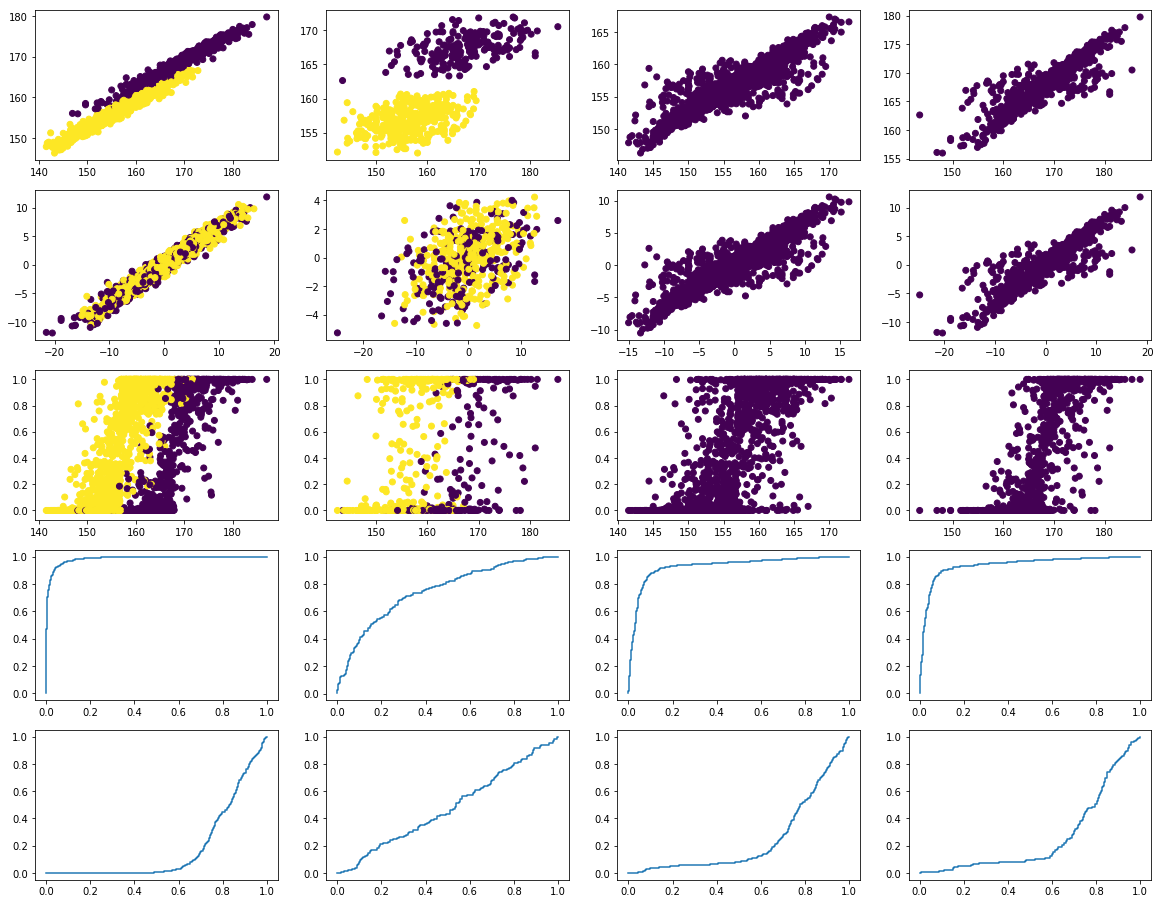

              MSE        R2     auc_b     auc_t
trn     30.934757  0.484211  0.985926  0.182932
val     34.328853  0.432136  0.750083  0.479406
female  28.043737  0.000000  0.929022  0.244773
male    37.961214  0.000000  0.937083  0.261321


In [58]:
m=RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,n_jobs=-1, oob_score=True)
results_rf={}
for i,snp in zip([50,100,200,300,500],snp_list):
    print(i)
    results_rf[i]=[tmp(tz_meta,s,tz_plink,ml=m) for s in [snp['tz_a'],set(snp['tz_a']+snp['tz_f']+snp['tz_m'])]]

In [88]:
results_rf

{50: [(         rt        rv        rf        rm        ht        hv        hf  \
   r  0.829749  0.055721  0.669923  0.645455  0.911214  0.463448  0.669218   
   c  0.829749  0.055721  0.669923  0.645455  0.911214  0.463448  0.669218   
   b  0.620228  0.074193  0.502434  0.494486  0.803449  0.473626  0.502475   
   t  0.586734  0.081805  0.464275  0.487664  0.786022  0.478217  0.465235   
   
            hm  
   r  0.647586  
   c  0.647586  
   b  0.497339  
   t  0.489143  ,
             rt         rv         rf         rm         ht         hv  \
   r   5.280459  32.696054   9.256588  13.458965   5.324979  32.435957   
   c   5.280459  32.696054   9.256588  13.458965   5.324979  32.435957   
   b  11.778879  32.056458  13.953598  19.189912  11.788245  31.820688   
   t  12.817731  31.792900  15.023719  19.448889  12.833451  31.543126   
   
             hf         hm  
   r   9.276358  13.378075  
   c   9.276358  13.378075  
   b  13.952466  19.081615  
   t  14.996799  19.392758

In [43]:
def tmp(meta,snp,tz_plink,val_idx,ml=linear_model.LinearRegression(),regr=regr):

    tz_snp_index = [i for i,x in enumerate(tz_plink[0].snp) if x in snp]
    tz_sample_index = [i for i,x in enumerate(tz_plink[1].iid) if x in list(meta.index)]
    tz_sub=plink_slice(tz_plink,tz_snp_index,tz_sample_index)
    
    all_bim = tz_sub[0]
    all_fam = tz_sub[1]
    all_bed_T= pd.DataFrame(tz_sub[2].compute()).T
    all_bed_T.fillna(-1,inplace=True)
    all_bed_T.index = list(all_fam.iid)
    all_bed_T.columns=list(all_bim.snp)
    print(all_bim.shape,all_fam.shape,all_bed_T.shape)
    
    #samp_size=len(meta)
    #train_ratio = 0.8
    #train_size = int(samp_size * train_ratio)
    #random.seed(1)
    #val_idx = random.sample(range(samp_size), samp_size-train_size)
    #print(samp_size,train_size)
    val_idx = val_idx
    m=ml
    X = all_bed_T
    y = meta
    mr = regr
    
    R2,MSE = super_model(m,X,y,val_idx,mr,pca=True)
    
    return R2,MSE

In [73]:
def super_model(m,X,y,val_idx,mr,pca=True):
    #pca
    if pca:        
        pca = PCA(.95)
        X=pd.DataFrame(pca.fit_transform(X))
        print(X.shape)
    #data    
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_val,yb_trn),(yt_val,yt_trn)) = split_by_idx(val_idx,y.biclass,y.triclass)
     
    tz_idx = boo2idx(y.gender==2)
    ((tz,os), (y_tz,y_os)) = split_by_idx(tz_idx, X.values, np.array(y.residual))
    ((gn_tz,gn_os),(gn_y_tz,gn_y_os)) = split_by_idx(tz_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_tz,yb_os),(yt_tz,yt_os)) = split_by_idx(tz_idx,y.biclass,y.triclass)
    #print([x.shape for x in [trn,val,tz,os,tes]])
    
    #sv_idx = boo2idx(gn_val[:,0]==2)
    #((val_f,val_m), (y_val_f,y_val_m)) = split_by_idx(sv_idx, val, y_val)
    #((gn_val_f,gn_val_m),(gn_y_val_f,gn_y_val_m)) = split_by_idx(sv_idx, gn_val, gn_y_trn)
    #((yb_val_f,yb_val_m),(yt_val_f,yt_val_m)) = split_by_idx(sv_idx,yb_val,yt_val)
    #model
    ml = m
    ml.fit(trn, y_trn)
    
    mb = linear_model.LogisticRegression()
    mb.fit(trn, yb_trn)
    
    mt = linear_model.LogisticRegression()
    mt.fit(trn, yt_trn)
    
    #
    yr = [y_trn,y_val,y_tz,y_os]
    yh = [gn_y_trn,gn_y_val,gn_y_tz,gn_y_os]
    yb = [yb_trn,yb_val,yb_tz,yb_os]
    yt = [yt_trn,yt_val,yt_tz,yt_os]
    gd = [gn_trn[:,0],gn_val[:,0],gn_tz[:,0],gn_os[:,0]]
    #pred
    pbase = model_pred(mr,[gn_trn,gn_val,gn_tz,gn_os])
    pr = model_pred(ml,[trn,val,tz,os])
    pbi = model_pred(mb,[trn,val,tz,os])
    pbi_prob = model_pred(mb,[trn,val,tz,os],p=True)
    ptri =  model_pred(mt,[trn,val,tz,os])
    ptri_prob = model_pred(mt,[trn,val,tz,os],p=True)
    ph = [x+y for x,y in zip(pr,pbase)]
    pr_c = [np.clip(x,-20,20) for x in pr]
    ph_c = [x+y for x,y in zip(pr_c,pbase)]
    pr_b = [biclip(x,b) for x,b in zip(pr_c,pbi)]
    ph_b = [x+y for x,y in zip(pr_b,pbase)]
    pr_t = [triclip(x,b,t) for x,b,t in zip(pr_c,pbi,ptri)]
    ph_t = [x+y for x,y in zip(pr_t,pbase)]
    
    fpr_b,tpr_b,auc_b=[],[],[]
    for y,scores in zip(yb,pbi_prob):
        #print(y,scores)
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        auc_b.append(metrics.auc(fpr, tpr))
        fpr_b.append(fpr)
        tpr_b.append(tpr)
    #print('auc_b',auc_b)
    fpr_t,tpr_t,auc_t=[],[],[]
    for y,scores in zip(yt,ptri_prob):
        fpr, tpr, _ = metrics.roc_curve(y, scores,pos_label=1)
        auc_t.append(metrics.auc(fpr, tpr))
        fpr_t.append(fpr)
        tpr_t.append(tpr)  
    #print('auc_t',auc_t)
    f, axs = plt.subplots(5, 4,figsize=(20, 16))
    axs = axs.ravel()
    for i,x,y,z in zip(list(range(12)),yh+yr+yh,ph+pr+pbi_prob,gd+gd+gd):
        #print(i,x,y)
        axs[i].scatter(x,y,marker='o',c=z)
    for i,x,y in zip(list(range(12,21)),fpr_b+fpr_t,tpr_b+tpr_t):
        axs[i].plot(x,y)
    plt.show()
    
    print(pd.DataFrame({
        'auc_b':auc_b,
        'auc_t':auc_t,
        'R2':[metrics.r2_score(x,y) for x,y in zip(yh,pbase)],
        'MSE':[metrics.mean_squared_error(x,y) for x,y in zip(yh,pbase)]
    },index=['trn','val','female','male']))
    
    R2 = pd.DataFrame.from_records([[metrics.r2_score(x,y) for x,y in zip(yr+yh,t)] 
           for t in [pr+ph,pr_c+ph_c,pr_b+ph_b,pr_t+ph_t]],index=['r','c','b','t'],
                                  columns=['rt','rv','rf','rm','ht','hv','hf','hm'])
    MSE = pd.DataFrame.from_records([[metrics.mean_squared_error(x,y) for x,y in zip(yr+yh,t)] 
           for t in [pr+ph,pr_c+ph_c,pr_b+ph_b,pr_t+ph_t]],index=['r','c','b','t'],
                                  columns=['rt','rv','rf','rm','ht','hv','hf','hm'])
    #max(ml.coef_),min(ml.coef_)
    return R2,MSE

In [ ]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    if algorithm == mixture.GaussianMixture:
        labels = algorithm(*args, **kwds).fit(data)
        labels = labels.predict(data)
    else:
        labels = algorithm(*args, **kwds).fit_predict(data)
        
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[1], data.T[5], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.10, -2.40, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    data = dict(type = 'choropleth', 
           locations = wh.index,
           locationmode = 'country names',
           z = labels, 
           text = wh.index,
           colorbar = {'title':'Cluster Group'})
    layout = dict(title = format(str(algorithm.__name__)), 
             geo = dict(showframe = False, 
                       projection = {'type': 'Mercator'}))
    choromap3 = go.Figure(data = [data], layout=layout)
    iplot(choromap3)

In [ ]:
def train_model(m,X,y,val_idx,mr):
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))

    ml = m
    ml.fit(trn, y_trn)


    pr_trn = np.clip(ml.predict(trn),-20,20)
    ph_trn = mr.predict(gn_trn)+pr_trn
    pr_val = np.clip(ml.predict(val),-20,20)
    ph_val = mr.predict(gn_val)+pr_val
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(y_val,pr_val,c=gn_val[:,0], marker='o')
    ax3.scatter(gn_y_trn,ph_trn,c=gn_trn[:,1], marker='o')
    ax4.scatter(gn_y_val,ph_val,c=gn_val[:,1], marker='o')

    plt.title(n);
    plt.show()

    score=(ml.score(trn, y_trn), ml.score(val, y_val),
                  rsqure(pr_trn,y_trn),rsqure(pr_val,y_val),
                  rsqure(ph_trn,gn_y_trn),rsqure(ph_val,gn_y_val),
                  max(ml.coef_),min(ml.coef_))
    return (ml,score)


In [176]:


def train_model(m,X,y,val_idx,mr):
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_val,yb_trn),(yt_val,yt_trn)) = split_by_idx(val_idx,y.biclass,y.triclass)
         
    ml = m
    ml.fit(trn, y_trn)
    
    mb = linear_model.LogisticRegression()
    mb.fit(trn, yb_trn)
    
    mt = linear_model.LogisticRegression()
    mt.fit(trn, yt_trn)

    pr_trn = np.clip(ml.predict(trn),-20,20)
    ph_trn = mr.predict(gn_trn)+pr_trn
    pr_val = np.clip(ml.predict(val),-20,20)
    ph_val = mr.predict(gn_val)+pr_val
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(y_val,pr_val,c=gn_val[:,0], marker='o')
    ax3.scatter(gn_y_trn,ph_trn,c=gn_trn[:,1], marker='o')
    ax4.scatter(gn_y_val,ph_val,c=gn_val[:,1], marker='o')

    plt.title(n);
    plt.show()
    pb_val = mb.predict(val)
    pt_val = mt.predict(val)
    tmp=pd.DataFrame({'yb':yb_val,'yt':yt_val,'pb':pb_val,'pt':pt_val,'v':1})
    print(tmp.pivot_table(['v'],index=['yb'],columns=['pb'],aggfunc=np.sum))
    print(tmp.pivot_table(['v'],index=['yt'],columns=['pt'],aggfunc=np.sum))
    
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(biclip(pr_val,pb_val,pt_val),pr_val,c=pt_val, marker='o')
    ax3.scatter(y_val,pr_val,c=pt_val, marker='o')
    ax4.scatter(y_val,biclip(pr_val,pb_val,pt_val),c=pt_val, marker='o')

    plt.title(n);
    plt.show()
    
    score=(ml.score(trn, y_trn), ml.score(val, y_val),
                  rsqure(pr_trn,y_trn),rsqure(pr_val,y_val),
                  rsqure(ph_trn,gn_y_trn),rsqure(ph_val,gn_y_val),
                  max(ml.coef_),min(ml.coef_))
    return (ml,mb,mt,score)

def topsnp_model(m,X,y,val_idx,mr,Xt,yt,topn=[500, 200, 100, 50, 20, 10]):
    score={}
    for n in topn: 
        var_idx = list(range(n))
        ml,mb,mt,score[n] = train_model(m,X.iloc[:,var_idx],y,val_idx,mr)
        ph_test = mr.predict(yt[['gender','nationality']].values)+biclip(np.clip(ml.predict(Xt.iloc[:,var_idx]),-20,20),mb.predict(Xt.iloc[:,var_idx]),mt.predict(Xt.iloc[:,var_idx]))
        challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
        challenge.submit(ph_test.tolist())
        challenge.disconnect()
    return pd.DataFrame(score)

## 2.SNPs from GWAS of TZ2014

# Build Model

## Data Prepare

In [10]:
all_bed_T = pd.read_pickle(TMP_PATH/'all_bed_T_top10000.pk')

In [165]:
sum(tmp.astype(np.float32))

783.0

In [276]:
X = all_bed_T
X['gender'] = pd.Series(list(all_meta.gender),index=X.index)
X['nationality'] = pd.Series(list((all_meta.nationality=='PROBLEM').astype(np.int)),index=X.index)
X.fillna(-1,inplace=True)
y = all_meta.height

df_test = os_sub_test_align.T
df_test['gender']=pd.Series(list(os_meta_test.SNPSEX[[int(x) for x in list(os_plink_test[1].iid)]]),index=df_test.index)
df_test['nationality'] = 1
#Replace nan values in the training and testing set with an arbitrary number (-1)
df_test.fillna(-1,inplace=True)

### Linear model for os data

## Sample seperation

3530 2647


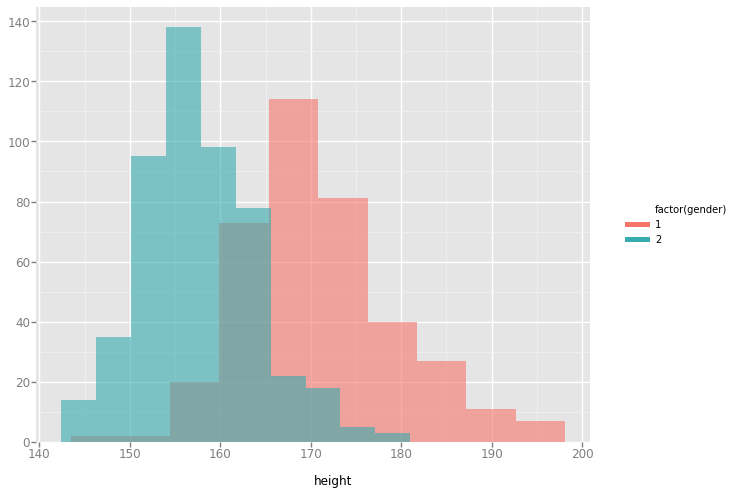

<ggplot: (-9223363300284316977)>

In [272]:
samp_size=len(all_meta)
train_ratio = 0.75
#train_ratio = 0.9
train_size = int(samp_size * train_ratio)

import random
val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)
ggplot( aes(x='height',fill='factor(gender)'),data=all_meta.loc[val_idx]) +\
    geom_histogram(alpha=0.6)

## Random Forest

In [282]:
y = np.array(y)

In [283]:
from sklearn.ensemble import RandomForestRegressor
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, y)

m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [3]:
preds = m.predict(val)

NameError: name 'm' is not defined

In [285]:
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_

(0.8439407662079724, 0.11804699118137751, 0.0804589756030738)

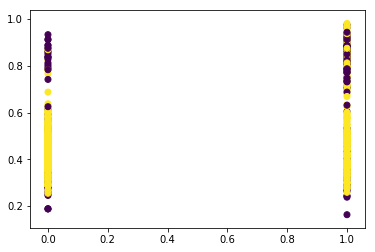

In [286]:
plt.scatter(y_val,preds,c=list(val[:,7726]), marker='o')

## NN1

In [ ]:
def NN_model()

In [85]:
def NN_Learner(meta,snp,tz_plink,ml=linear_model.LinearRegression(),regr=regr,pca=True):

    tz_snp_index = [i for i,x in enumerate(tz_plink[0].snp) if x in snp]
    tz_sample_index = [i for i,x in enumerate(tz_plink[1].iid) if x in list(meta.index)]
    tz_sub=plink_slice(tz_plink,tz_snp_index,tz_sample_index)
    
    all_bim = tz_sub[0]
    all_fam = tz_sub[1]
    all_bed_T= pd.DataFrame(tz_sub[2].compute()).T
    all_bed_T.fillna(-1,inplace=True)
    all_bed_T.index = list(all_fam.iid)
    all_bed_T.columns=list(all_bim.snp)
    print(all_bim.shape,all_fam.shape,all_bed_T.shape)
    
    samp_size=len(meta)
    train_ratio = 0.8
    train_size = int(samp_size * train_ratio)
    random.seed(1)
    val_idx = random.sample(range(samp_size), samp_size-train_size)
    print(samp_size,train_size)
    
    m=ml
    X = all_bed_T
    y = meta
    mr = regr
    
    m = nn_model(m,X,y,val_idx,mr,pca=pca)
    
    return m

In [89]:
def nn_model(m,X,y,val_idx,mr,pca=True):
    #pca
    if pca:        
        pca = PCA(.95)
        X=pd.DataFrame(pca.fit_transform(X))
        print(X.shape)
    #data
    X['gender']=pd.Series(list(y.gender),index=X.index)
    X['nationality']=pd.Series(list(y.nationality),index=X.index)
    #X=pd.concat([X, y[['gender','nationality']]], axis=1)
    print(X.shape)
    cat_vars = ['gender','nationality']
    y = y.residual
    md = ColumnarModelData.from_data_frame(PATH, val_idx, X, y.astype(np.float32), cat_flds=cat_vars, bs=64)
    cat_sz = [('gender',3),('nationality',2)]
    print(cat_sz)
    emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
    print(emb_szs)

    y_range = (130,210)

    m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                       0, 1, [256,128,64], [0.5,0.3,0])
    lr = 1e-3
    m.lr_find()
    m.sched.plot()
    m.fit(lr, 3,metrics=[metrics.r2_score,metrics.mean_squared_error], cycle_len=10)
    return m

(500, 7) (2747, 7) (2747, 500)
2747 2197
(2747, 502)
[('gender', 3), ('nationality', 2)]
[(3, 2), (2, 1)]


 49%|████▊     | 17/35 [00:00<00:00, 167.80it/s, loss=39.4]


epoch      trn_loss   val_loss   r2_score   mean_squared_error 
    0      38.028437  35.135227  -735.063737 35.135228 
    1      33.71138   34.47172   -1565.72258 34.47172      
    2      32.159708  33.690207  -871.400868 33.690208     
    3      30.947124  32.703393  -284.170785 32.703393     
    4      29.949424  31.386429  -80.745528 31.386429      
    5      29.236139  29.796558  -37.720747 29.796559      
    6      28.052936  27.927441  -15.866077 27.92744       
    7      27.03096   27.278334  -12.102844 27.278334      
    8      26.131695  26.904948  -10.335055 26.904948      
    9      25.499191  26.894388  -10.233735 26.894389      
    10     25.515028  26.544644  -7.021991  26.544643      
    11     25.081487  23.920877  -4.066026  23.920877      
    12     23.449426  24.228447  -4.866455  24.228446      
    13     22.65313   22.989453  -3.305938  22.989453      
    14     21.610464  21.75661   -1.915976  21.756611      
    15     20.871992  21.604129  -1.3552

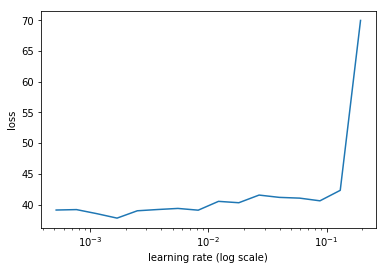

In [91]:
m=NN_Learner(tz_meta,snp_list[4]['tz_a'],tz_plink,pca=False)

In [1]:
cat_vars = ['gender','nationality']

md = ColumnarModelData.from_data_frame(PATH, val_idx, X, y.astype(np.float32), cat_flds=cat_vars, bs=128)
cat_sz = [('gender':3,'nationality':2)]
print(cat_sz)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
print(emb_szs)

y_range = (130,210)

m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                   0, 1, [128,64,16], [0,0.1,0.1])
lr = 1e-3
m.lr_find()
m.sched.plot()
m.fit(lr, 3, cycle_len=3)

NameError: name 'X' is not defined

In [198]:
#m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
#                   0, 1, [256,128,64], [0.3,0.5,0.3], y_range=y_range)

In [213]:
m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                   0, 1, [128,64,16], [0,0.1,0.1])

lr = 1e-3
m.lr_find()
m.sched.plot()
m.fit(lr, 3, cycle_len=3)

In [230]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      56.733091  62.744966 
    1      49.164127  62.002885                            
    2      44.179577  61.256397                          
    3      42.012801  60.872404                            
    4      39.967664  60.322566                          
    5      43.533669  60.629964                            
    6      42.154946  58.021469                          
    7      41.29138   57.008608                          
    8      40.034128  56.676835                          
    9      40.916238  60.169139                            



[array([60.16914])]

In [983]:
m.save('nn_model1') #R2=0.355

 24%|██▍       | 12/50 [00:00<00:00, 119.82it/s, loss=43.2]

epoch      trn_loss   val_loss                             
    0      80.888028  151.194055



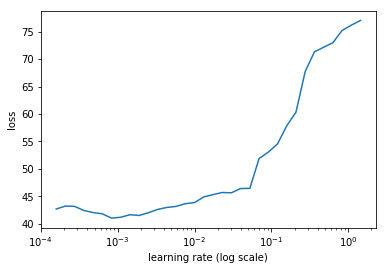

In [984]:
m.lr_find()
m.sched.plot()

In [985]:
m.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss                             
    0      50.995664  42.544632 
    1      43.480691  41.338056                            
    2      42.126355  41.464497                            



[array([41.4645])]

In [1026]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      57.78584   49.578513 
    1      53.775634  46.085355                            
    2      51.614049  43.825487                            
    3      50.302809  40.732563                            
    4      49.565065  43.737697                           
    5      47.954103  40.983987                            
    6      47.264173  38.763312                          
    7      46.305101  38.572067                            
    8      45.49319   38.968085                            
    9      46.022123  39.092998                            



[array([39.093])]

In [987]:
m.save('nn_model2') #R2=0.436

In [9]:
m.load('nn_model2')

NameError: name 'm' is not defined

In [231]:
# Predict the heights for the test set
heights = m.predict(True)
heights=heights.reshape(137)
heights = heights.tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : adf40834-afd7-4b4d-bb1d-a0116c14b777


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : adf40834-afd7-4b4d-bb1d-a0116c14b777


100% |██████████|[00:00<00:00]  109.49% /s] 


CrowdAI.Event.Job.INFO : (adf40834-afd7-4b4d-bb1d-a0116c14b777) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.073840333075 ; MSE : 94.1487447856
CrowdAI.Event.Job.COMPLETE : adf40834-afd7-4b4d-bb1d-a0116c14b777	   🍺 


## NN2

In [972]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(y)
y_range = (140,200)

In [317]:
maf=pd.read_csv('../predict_height/lib/maf.csv',index_col=0)

In [321]:
sum([x in maf.index for x in all_bim.snp])

628

In [792]:
# Instantiate a linear model
x_train=X
y_train=y
x_test=df_test
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)

In [793]:
#Convert heights from np.array to a list (to ensure it is JSON serializable)
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")

heights = heights.tolist()
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 
100% |██████████|[00:00<00:00]  102.69% /s] 
          
  0% |          |[16:49<?]  ?% /s] .69% /s] 


CrowdAI.Event.Job.INFO : (bc1ef311-9598-4a6c-a9a2-cce75662d779) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.0365818509984 ; MSE : 105.373709981
CrowdAI.Event.Job.COMPLETE : bc1ef311-9598-4a6c-a9a2-cce75662d779	   🍺 
